<a href="https://colab.research.google.com/github/DanAkarca/modular_experts/blob/main/testing_varied_architectures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Experiement: Testing homogeneous, modular and heterogeneous modular mixture of network experiments

In [29]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple, Dict
import seaborn as sns
from tqdm import tqdm
import pandas as pd

def generate_complex_patterns(num_samples: int, grid_size: int = 8) -> Tuple[torch.Tensor, torch.Tensor]:
    """Generate complex pattern completion data with biased sampling towards extreme densities"""
    inputs = []
    targets = []

    # Define patterns and their target probabilities
    pattern_configs = {
        'sparse_stripes': {'spacing': 4, 'width': 1, 'prob': 0.2},      # Very sparse
        'dense_stripes': {'spacing': 3, 'width': 2, 'prob': 0.2},       # Very dense
        'sparse_blocks': {'density': 0.2, 'prob': 0.15},                # Very sparse
        'dense_blocks': {'density': 0.8, 'prob': 0.15},                 # Very dense
        'thin_spiral': {'thickness': 0.5, 'prob': 0.1},                 # Very sparse
        'thick_spiral': {'thickness': 2.5, 'prob': 0.1},                # Very dense
        'sparse_random': {'density': 0.1, 'prob': 0.05},                # Extremely sparse
        'dense_random': {'density': 0.9, 'prob': 0.05}                  # Extremely dense
    }

    def create_stripes(size, spacing, width):
        pattern = torch.zeros((size, size))
        for i in range(size):
            for j in range(size):
                if (i + j) % spacing < width:
                    pattern[i, j] = 1
        return pattern

    def create_blocks(size, density):
        pattern = torch.zeros((size, size))
        block_size = 2
        num_blocks = size // block_size
        for i in range(0, size, block_size):
            for j in range(0, size, block_size):
                if torch.rand(1).item() < density:
                    pattern[i:i+block_size, j:j+block_size] = 1
        return pattern

    def create_spiral(size, thickness):
        pattern = torch.zeros((size, size))
        center = size // 2
        for i in range(size):
            for j in range(size):
                x, y = i - center, j - center
                r = np.sqrt(x*x + y*y)
                angle = np.arctan2(y, x)
                if angle < 0:
                    angle += 2 * np.pi
                a = 2
                theta = r / a
                spiral_r = a * (angle / (2 * np.pi))
                if abs(r - spiral_r) < thickness:
                    pattern[i, j] = 1
        return pattern

    def create_random_pattern(size, density):
        return (torch.rand((size, size)) < density).float()

    probabilities = [config['prob'] for config in pattern_configs.values()]
    pattern_types = list(pattern_configs.keys())

    for _ in range(num_samples):
        # Sample pattern type according to specified probabilities
        pattern_type = np.random.choice(pattern_types, p=probabilities)
        config = pattern_configs[pattern_type]

        # Generate pattern based on type
        if 'stripes' in pattern_type:
            pattern = create_stripes(grid_size, config['spacing'], config['width'])
        elif 'blocks' in pattern_type:
            pattern = create_blocks(grid_size, config['density'])
        elif 'spiral' in pattern_type:
            pattern = create_spiral(grid_size, config['thickness'])
        else:  # random
            pattern = create_random_pattern(grid_size, config['density'])

        # Create masked input with biased masking
        masked = pattern.clone()

        if np.random.random() < 0.3:
            # Block masking with varying sizes
            block_size = np.random.randint(2, 4)
            num_blocks = np.random.randint(1, 3)

            for _ in range(num_blocks):
                start_i = np.random.randint(0, grid_size - block_size)
                start_j = np.random.randint(0, grid_size - block_size)
                masked[start_i:start_i+block_size, start_j:start_j+block_size] = 0
        else:
            # Biased random masking
            density = pattern.mean().item()
            if density > 0.5:
                # For dense patterns, mask more 1s
                mask = torch.rand(grid_size, grid_size) > (0.7 * pattern + 0.1)
            else:
                # For sparse patterns, mask more 0s
                mask = torch.rand(grid_size, grid_size) > (0.7 * (1 - pattern) + 0.1)

            masked[mask] = 0

        inputs.append(masked.flatten())
        targets.append(pattern.flatten())

    return torch.stack(inputs), torch.stack(targets)

def analyze_pattern_statistics(num_samples=1000, grid_size=8):
    """Analyze the statistics of generated patterns"""
    inputs, targets = generate_complex_patterns(num_samples, grid_size)

    # Overall statistics
    mean_density = targets.mean().item()
    std_density = targets.std().item()

    print(f"Pattern Statistics:")
    print(f"Mean density: {mean_density:.3f}")
    print(f"Std density: {std_density:.3f}")
    print(f"Random baseline accuracy: {max(mean_density, 1-mean_density)*100:.1f}%")

    # Visualize some examples
    fig, axs = plt.subplots(4, 4, figsize=(12, 12))
    fig.suptitle("Sample Patterns")

    for i in range(4):
        for j in range(4):
            idx = i * 4 + j
            if idx < len(targets):
                axs[i, j].imshow(targets[idx].reshape(grid_size, grid_size), cmap='Blues')
                density = targets[idx].mean().item()
                axs[i, j].set_title(f'Density: {density:.2f}')
                axs[i, j].axis('off')

    plt.tight_layout()
    plt.show()

class BaseExpert(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
        )
        self.param_count = sum(p.numel() for p in self.parameters())

    def forward(self, x):
        return torch.sigmoid(self.net(x))

class HomogeneousNetwork(nn.Module):
    def __init__(self, input_size: int, total_params: int):
        super().__init__()
        self.hidden_size = total_params // (3 * input_size)
        self.expert = BaseExpert(input_size, self.hidden_size, input_size)

    def forward(self, x):
        return self.expert(x)

class ModularHomogeneous(nn.Module):
    def __init__(self, input_size: int, total_params: int, num_experts: int):
        super().__init__()
        self.hidden_size = total_params // (3 * input_size * num_experts)
        self.num_experts = num_experts
        self.input_size = input_size

        self.experts = nn.ModuleList([
            BaseExpert(input_size, self.hidden_size, input_size)
            for _ in range(num_experts)
        ])
        self.router = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, num_experts)
        )

    def forward(self, x):
        batch_size = x.shape[0] if len(x.shape) > 1 else 1
        if len(x.shape) == 1:
            x = x.unsqueeze(0)

        routing_weights = torch.softmax(self.router(x), dim=-1)
        expert_outputs = torch.stack([expert(x) for expert in self.experts])
        expert_outputs = expert_outputs.permute(1, 0, 2)
        routing_weights = routing_weights.unsqueeze(-1)

        output = torch.sum(routing_weights * expert_outputs, dim=1)
        return output.squeeze(0) if batch_size == 1 else output

class ModularHeterogeneous(nn.Module):
    def __init__(self, input_size: int, total_params: int, expert_ratios: List[float]):
        super().__init__()
        self.input_size = input_size
        self.num_experts = len(expert_ratios)

        total_ratio = sum(expert_ratios)
        expert_sizes = [int((ratio/total_ratio) * total_params // (3 * input_size))
                       for ratio in expert_ratios]

        self.experts = nn.ModuleList([
            BaseExpert(input_size, size, input_size)
            for size in expert_sizes
        ])

        self.router = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, self.num_experts)
        )

    def forward(self, x):
        batch_size = x.shape[0] if len(x.shape) > 1 else 1
        if len(x.shape) == 1:
            x = x.unsqueeze(0)

        routing_weights = torch.softmax(self.router(x), dim=-1)
        expert_outputs = torch.stack([expert(x) for expert in self.experts])
        expert_outputs = expert_outputs.permute(1, 0, 2)
        routing_weights = routing_weights.unsqueeze(-1)

        output = torch.sum(routing_weights * expert_outputs, dim=1)
        return output.squeeze(0) if batch_size == 1 else output

def calculate_accuracies(outputs: torch.Tensor, targets: torch.Tensor, threshold: float = 0.5) -> Tuple[float, float]:
    """Calculate both pixel-wise and pattern-wise accuracy"""
    predictions = (outputs > threshold).float()
    targets = (targets > threshold).float()

    # Pattern-wise accuracy (whole pattern must be correct)
    correct_patterns = torch.all(predictions == targets, dim=1)
    pattern_acc = correct_patterns.float().mean().item() * 100

    # Pixel-wise accuracy
    pixel_acc = (predictions == targets).float().mean().item() * 100

    return pixel_acc, pattern_acc

def calculate_baselines(targets: torch.Tensor) -> Tuple[float, float]:
    """Calculate random baselines for both pixel-wise and pattern-wise accuracy"""
    # For pixel-wise baseline
    p_ones = targets.mean().item()
    pixel_baseline = max(p_ones, 1-p_ones) * 100

    # For pattern-wise baseline (need all pixels correct)
    num_pixels = targets.shape[1]
    pattern_baseline = (max(p_ones, 1-p_ones) ** num_pixels) * 100

    return pixel_baseline, pattern_baseline

def train_and_evaluate(model, train_data, train_targets, val_data, val_targets, epochs=100):
    """Train and evaluate with both accuracy metrics"""
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCELoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10)

    # History dictionaries
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_pixel_acc': [],
        'val_pixel_acc': [],
        'train_pattern_acc': [],
        'val_pattern_acc': [],
        'expert_usage': [] if hasattr(model, 'router') else None
    }

    best_val_loss = float('inf')
    best_state_dict = None

    for epoch in tqdm(range(epochs)):
        # Training
        model.train()
        optimizer.zero_grad()

        outputs = torch.sigmoid(model(train_data))
        loss = criterion(outputs, train_targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = torch.sigmoid(model(val_data))
            val_loss = criterion(val_outputs, val_targets)

            # Calculate both accuracy metrics
            train_pixel_acc, train_pattern_acc = calculate_accuracies(outputs, train_targets)
            val_pixel_acc, val_pattern_acc = calculate_accuracies(val_outputs, val_targets)

            # Record metrics
            history['train_loss'].append(loss.item())
            history['val_loss'].append(val_loss.item())
            history['train_pixel_acc'].append(train_pixel_acc)
            history['val_pixel_acc'].append(val_pixel_acc)
            history['train_pattern_acc'].append(train_pattern_acc)
            history['val_pattern_acc'].append(val_pattern_acc)

            # Track expert usage if applicable
            if hasattr(model, 'router') and epoch % 10 == 0:
                expert_weights = analyze_expert_usage(model, train_data)
                if expert_weights is not None and history['expert_usage'] is not None:
                    history['expert_usage'].append(expert_weights)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_state_dict = model.state_dict().copy()

            scheduler.step(val_loss)

        if epoch % 10 == 0:
            print(f'\nEpoch {epoch}/{epochs}:')
            print(f'Train Loss: {loss.item():.4f}')
            print(f'Train Pixel Acc: {train_pixel_acc:.2f}%, Pattern Acc: {train_pattern_acc:.2f}%')
            print(f'Val Pixel Acc: {val_pixel_acc:.2f}%, Pattern Acc: {val_pattern_acc:.2f}%')

    model.load_state_dict(best_state_dict)
    return history

def analyze_expert_usage(model: nn.Module, data: torch.Tensor, num_samples: int = 100) -> np.ndarray:
    """Analyze how different experts are used across different input patterns"""
    model.eval()
    with torch.no_grad():
        if hasattr(model, 'router'):
            indices = np.random.choice(len(data), num_samples, replace=False)
            samples = data[indices]
            routing_weights = torch.softmax(model.router(samples), dim=-1)
            return routing_weights.numpy()
    return None

def plot_enhanced_metrics(histories: Dict, epochs: int, random_baseline: float):
    """Plot enhanced training metrics with random baseline and confidence intervals"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    # Color palette
    colors = sns.color_palette("husl", len(histories))

    # Plot losses
    for (name, history), color in zip(histories.items(), colors):
        ax1.plot(history['train_loss'], label=f'{name} (Train)', color=color)
        ax1.plot(history['val_loss'], label=f'{name} (Val)',
                linestyle='--', color=color, alpha=0.7)

    ax1.set_title('Loss Over Time', fontsize=12, pad=10)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss (BCE)')
    ax1.set_yscale('log')
    ax1.grid(True, alpha=0.3)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Plot accuracies with baseline
    for (name, history), color in zip(histories.items(), colors):
        ax2.plot(history['train_acc'], label=f'{name} (Train)', color=color)
        ax2.plot(history['val_acc'], label=f'{name} (Val)',
                linestyle='--', color=color, alpha=0.7)

    # Add random baseline
    ax2.axhline(y=random_baseline, color='red', linestyle=':',
                label='Random Baseline', alpha=0.7)

    ax2.set_title('Accuracy Over Time', fontsize=12, pad=10)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.grid(True, alpha=0.3)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Plot final performance comparison
    model_names = list(histories.keys())
    final_train_acc = [hist['train_acc'][-1] for hist in histories.values()]
    final_val_acc = [hist['val_acc'][-1] for hist in histories.values()]

    x = np.arange(len(model_names))
    width = 0.35

    bars1 = ax3.bar(x - width/2, final_train_acc, width, label='Train')
    bars2 = ax3.bar(x + width/2, final_val_acc, width, label='Validation')
    ax3.axhline(y=random_baseline, color='red', linestyle=':',
                label='Random Baseline', alpha=0.7)

    ax3.set_title('Final Model Performance', fontsize=12, pad=10)
    ax3.set_xticks(x)
    ax3.set_xticklabels(model_names, rotation=45, ha='right')
    ax3.set_ylabel('Accuracy (%)')
    ax3.grid(True, alpha=0.3)
    ax3.legend()

    # Add value labels on bars
    def autolabel(bars):
        for bar in bars:
            height = bar.get_height()
            ax3.annotate(f'{height:.1f}%',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(bars1)
    autolabel(bars2)

    # Keep ax4 for expert usage plot
    ax4.set_title('Expert Usage Analysis', fontsize=12, pad=10)
    plt.tight_layout()
    return fig, (ax1, ax2, ax3, ax4)

def plot_expert_usage_patterns(ax, expert_weights: np.ndarray, model_name: str):
    """Plot expert usage patterns with enhanced visualization"""
    if expert_weights is None:
        ax.text(0.5, 0.5, 'No expert data available\n(Homogeneous Model)',
                ha='center', va='center')
        return

    # Calculate mean usage and confidence intervals
    mean_usage = expert_weights.mean(axis=0)
    std_usage = expert_weights.std(axis=0)

    # Create violin plot
    parts = ax.violinplot([expert_weights[:, i] for i in range(expert_weights.shape[1])],
                         showmeans=True, showextrema=True)

    # Customize violin plot
    colors = sns.color_palette("husl", expert_weights.shape[1])
    for i, pc in enumerate(parts['bodies']):
        pc.set_facecolor(colors[i])
        pc.set_alpha(0.7)

    parts['cmeans'].set_color('red')
    parts['cmins'].set_color('black')
    parts['cmaxes'].set_color('black')

    # Add mean values as text
    for i, mean in enumerate(mean_usage):
        ax.text(i+1, mean, f'{mean:.2f}',
                ha='center', va='bottom')

    ax.set_xticks(np.arange(1, len(mean_usage) + 1))
    ax.set_xticklabels([f'Expert {i+1}' for i in range(len(mean_usage))])
    ax.set_ylabel('Expert Usage Weight')
    ax.set_title(f'Expert Usage Distribution - {model_name}')
    ax.grid(True, alpha=0.3)

def visualize_pattern_completion(model: nn.Module,
                               test_data: torch.Tensor,
                               test_targets: torch.Tensor,
                               model_name: str,
                               grid_size: int = 8,
                               num_examples: int = 5):
    """Visualize pattern completion results with enhanced presentation"""
    model.eval()
    with torch.no_grad():
        test_outputs = torch.sigmoid(model(test_data))  # Added sigmoid here

    fig = plt.figure(figsize=(15, 6))
    plt.suptitle(f'Pattern Completion Results - {model_name}', fontsize=14, y=1.02)

    # Create a custom colormap with white background
    cmap = plt.cm.Blues
    cmap.set_bad(color='red', alpha=0.5)

    for i in range(num_examples):
        # Input
        ax1 = plt.subplot(3, num_examples, i + 1)
        sns.heatmap(test_data[i].reshape(grid_size, grid_size),
                   cmap=cmap, cbar=False, square=True, ax=ax1)
        if i == 0:
            ax1.set_ylabel('Input')
        ax1.set_xticks([])
        ax1.set_yticks([])

        # Prediction
        ax2 = plt.subplot(3, num_examples, i + 1 + num_examples)
        sns.heatmap(test_outputs[i].reshape(grid_size, grid_size),
                   cmap=cmap, cbar=False, square=True, ax=ax2)
        if i == 0:
            ax2.set_ylabel('Prediction')
        ax2.set_xticks([])
        ax2.set_yticks([])

        # Target
        ax3 = plt.subplot(3, num_examples, i + 1 + 2*num_examples)
        sns.heatmap(test_targets[i].reshape(grid_size, grid_size),
                   cmap=cmap, cbar=False, square=True, ax=ax3)
        if i == 0:
            ax3.set_ylabel('Target')
        ax3.set_xticks([])
        ax3.set_yticks([])

        # Add accuracy score for this example
        acc = (test_outputs[i].round() == test_targets[i]).float().mean().item()
        plt.text(grid_size/2, -1, f'Acc: {acc:.1%}',
                ha='center', va='center', transform=ax3.transData)

    plt.tight_layout()
    return fig

def plot_training_metrics(histories: Dict, pixel_baseline: float, pattern_baseline: float):
    """Plot enhanced training metrics with both accuracy types"""
    fig = plt.figure(figsize=(20, 10))
    gs = plt.GridSpec(2, 3, figure=fig)

    # Color palette
    colors = sns.color_palette("husl", len(histories))

    # 1. Loss plot
    ax_loss = fig.add_subplot(gs[0, 0])
    for (name, history), color in zip(histories.items(), colors):
        ax_loss.plot(history['train_loss'], label=f'{name} (Train)', color=color)
        ax_loss.plot(history['val_loss'], linestyle='--', color=color, alpha=0.7)
    ax_loss.set_title('Loss Over Time')
    ax_loss.set_xlabel('Epoch')
    ax_loss.set_ylabel('Loss (BCE)')
    ax_loss.set_yscale('log')
    ax_loss.grid(True, alpha=0.3)
    ax_loss.legend()

    # 2. Pixel-wise accuracy
    ax_pixel = fig.add_subplot(gs[0, 1])
    for (name, history), color in zip(histories.items(), colors):
        ax_pixel.plot(history['train_pixel_acc'], label=f'{name} (Train)', color=color)
        ax_pixel.plot(history['val_pixel_acc'], linestyle='--', color=color, alpha=0.7)
    ax_pixel.axhline(y=pixel_baseline, color='red', linestyle=':', label='Random Baseline')
    ax_pixel.set_title('Pixel-wise Accuracy')
    ax_pixel.set_xlabel('Epoch')
    ax_pixel.set_ylabel('Accuracy (%)')
    ax_pixel.grid(True, alpha=0.3)
    ax_pixel.legend()

    # 3. Pattern-wise accuracy
    ax_pattern = fig.add_subplot(gs[0, 2])
    for (name, history), color in zip(histories.items(), colors):
        ax_pattern.plot(history['train_pattern_acc'], label=f'{name} (Train)', color=color)
        ax_pattern.plot(history['val_pattern_acc'], linestyle='--', color=color, alpha=0.7)
    ax_pattern.axhline(y=pattern_baseline, color='red', linestyle=':', label='Random Baseline')
    ax_pattern.set_title('Pattern-wise Accuracy')
    ax_pattern.set_xlabel('Epoch')
    ax_pattern.set_ylabel('Accuracy (%)')
    ax_pattern.grid(True, alpha=0.3)
    ax_pattern.legend()

    # 4. Final performance comparison
    ax_final = fig.add_subplot(gs[1, :2])
    model_names = list(histories.keys())
    x = np.arange(len(model_names))
    width = 0.15

    # Plot pixel-wise accuracies
    pixel_train = [hist['train_pixel_acc'][-1] for hist in histories.values()]
    pixel_val = [hist['val_pixel_acc'][-1] for hist in histories.values()]
    pattern_train = [hist['train_pattern_acc'][-1] for hist in histories.values()]
    pattern_val = [hist['val_pattern_acc'][-1] for hist in histories.values()]

    ax_final.bar(x - 1.5*width, pixel_train, width, label='Pixel Train')
    ax_final.bar(x - 0.5*width, pixel_val, width, label='Pixel Val')
    ax_final.bar(x + 0.5*width, pattern_train, width, label='Pattern Train')
    ax_final.bar(x + 1.5*width, pattern_val, width, label='Pattern Val')

    ax_final.axhline(y=pixel_baseline, color='red', linestyle=':', label='Pixel Random')
    ax_final.axhline(y=pattern_baseline, color='darkred', linestyle=':', label='Pattern Random')

    ax_final.set_title('Final Model Performance')
    ax_final.set_xticks(x)
    ax_final.set_xticklabels(model_names, rotation=45, ha='right')
    ax_final.set_ylabel('Accuracy (%)')
    ax_final.grid(True, alpha=0.3)
    ax_final.legend()

    plt.tight_layout()
    return fig

def visualize_expert_specialization(model: nn.Module,
                                  data: torch.Tensor,
                                  targets: torch.Tensor,
                                  grid_size: int = 8,
                                  num_patterns: int = 4):
    """Enhanced visualization of expert specialization"""
    if not hasattr(model, 'router'):
        return None

    model.eval()
    with torch.no_grad():
        # Get routing weights and reorganize data by expert preference
        routing_weights = torch.softmax(model.router(data), dim=-1)
        num_experts = routing_weights.shape[1]

        # Create figure
        fig = plt.figure(figsize=(20, 4*num_experts))
        gs = plt.GridSpec(num_experts, num_patterns + 2, figure=fig)

        for expert_idx in range(num_experts):
            # Get patterns where this expert has highest weight
            expert_weight = routing_weights[:, expert_idx]
            top_indices = torch.argsort(expert_weight, descending=True)[:num_patterns]

            # Plot expert usage distribution
            ax_dist = fig.add_subplot(gs[expert_idx, 0])
            sns.kdeplot(expert_weight.numpy(), ax=ax_dist, fill=True)
            ax_dist.set_title(f'Expert {expert_idx + 1}\nUsage Distribution')
            ax_dist.set_xlabel('Routing Weight')

            # Plot expert statistics
            ax_stats = fig.add_subplot(gs[expert_idx, 1])
            pattern_densities = [targets[idx].mean().item() for idx in top_indices]
            ax_stats.boxplot(pattern_densities)
            ax_stats.set_title('Pattern Density\nDistribution')
            ax_stats.set_ylim(0, 1)

            # Plot top patterns
            for j, idx in enumerate(top_indices):
                ax_pattern = fig.add_subplot(gs[expert_idx, j + 2])
                sns.heatmap(data[idx].reshape(grid_size, grid_size),
                           cmap='Blues', cbar=False, square=True, ax=ax_pattern)
                ax_pattern.set_xticks([])
                ax_pattern.set_yticks([])
                density = targets[idx].mean().item()
                weight = expert_weight[idx].item()
                ax_pattern.set_title(f'w={weight:.2f}\nd={density:.2f}')

    plt.suptitle('Expert Specialization Analysis', fontsize=16, y=1.02)
    plt.tight_layout()
    return fig

def plot_all_visualizations(models: Dict[str, nn.Module],
                          histories: Dict[str, Dict],
                          data: torch.Tensor,
                          targets: torch.Tensor,
                          test_data: torch.Tensor,
                          test_targets: torch.Tensor,
                          epochs: int,
                          grid_size: int = 8):
    """Create all visualizations for the pattern completion task"""

    # Calculate random baseline
    random_baseline = calculate_random_baseline(targets)
    print(f"Random Baseline Accuracy: {random_baseline:.2f}%")

    # Create main metrics plot
    fig, (ax1, ax2, ax3, ax4) = plot_enhanced_metrics(histories, epochs, random_baseline)

    # Analyze and plot expert usage for modular models
    for name, model in models.items():
        if 'Modular' in name:
            expert_weights = analyze_expert_usage(model, data)
            if expert_weights is not None:
                plot_expert_usage_patterns(ax4, expert_weights, name)

    plt.show()

    # Plot pattern completion visualizations for each model
    for name, model in models.items():
        fig = visualize_pattern_completion(model, test_data, test_targets, name, grid_size)
        plt.show()

        # Plot expert specialization for modular models
        if 'Modular' in name:
            fig = visualize_expert_specialization(model, data, grid_size)
            if fig is not None:
                plt.show()

Starting Pattern Completion Experiment...
Using device: cuda

Generating datasets...

Baseline Accuracies:
Pixel-wise: 54.77%
Pattern-wise: 0.0000%

Analyzing dataset characteristics...


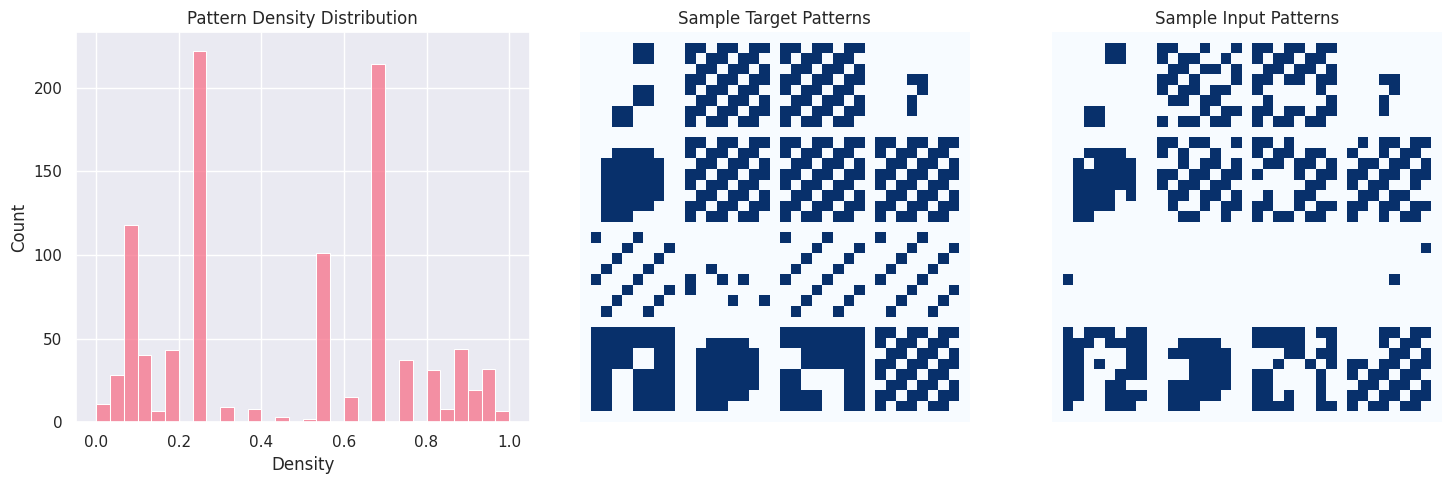


Initializing models...

Training models...

Training Homogeneous model...


  1%|          | 18/2000 [00:00<00:11, 174.28it/s]


Epoch 0/2000:
Train Loss: 0.7474
Train Pixel Acc: 45.23%, Pattern Acc: 0.50%
Val Pixel Acc: 43.00%, Pattern Acc: 0.50%

Epoch 10/2000:
Train Loss: 0.7378
Train Pixel Acc: 45.23%, Pattern Acc: 0.50%
Val Pixel Acc: 43.00%, Pattern Acc: 0.50%

Epoch 20/2000:
Train Loss: 0.7139
Train Pixel Acc: 45.23%, Pattern Acc: 0.50%
Val Pixel Acc: 43.00%, Pattern Acc: 0.50%

Epoch 30/2000:
Train Loss: 0.6875
Train Pixel Acc: 45.23%, Pattern Acc: 0.50%
Val Pixel Acc: 43.00%, Pattern Acc: 0.50%


  4%|▎         | 71/2000 [00:00<00:11, 166.04it/s]


Epoch 40/2000:
Train Loss: 0.6574
Train Pixel Acc: 45.23%, Pattern Acc: 0.50%
Val Pixel Acc: 43.00%, Pattern Acc: 0.50%

Epoch 50/2000:
Train Loss: 0.6313
Train Pixel Acc: 45.23%, Pattern Acc: 0.50%
Val Pixel Acc: 43.00%, Pattern Acc: 0.50%

Epoch 60/2000:
Train Loss: 0.6126
Train Pixel Acc: 45.75%, Pattern Acc: 0.20%
Val Pixel Acc: 43.56%, Pattern Acc: 0.00%

Epoch 70/2000:
Train Loss: 0.6021
Train Pixel Acc: 47.54%, Pattern Acc: 0.00%
Val Pixel Acc: 45.38%, Pattern Acc: 0.00%


  5%|▌         | 108/2000 [00:00<00:10, 173.80it/s]


Epoch 80/2000:
Train Loss: 0.5967
Train Pixel Acc: 49.12%, Pattern Acc: 0.00%
Val Pixel Acc: 45.77%, Pattern Acc: 0.00%

Epoch 90/2000:
Train Loss: 0.5936
Train Pixel Acc: 49.76%, Pattern Acc: 0.00%
Val Pixel Acc: 45.85%, Pattern Acc: 0.00%

Epoch 100/2000:
Train Loss: 0.5915
Train Pixel Acc: 49.73%, Pattern Acc: 0.00%
Val Pixel Acc: 45.80%, Pattern Acc: 0.00%

Epoch 110/2000:
Train Loss: 0.5902
Train Pixel Acc: 49.63%, Pattern Acc: 0.00%
Val Pixel Acc: 45.70%, Pattern Acc: 0.00%


  7%|▋         | 144/2000 [00:00<00:10, 176.87it/s]


Epoch 120/2000:
Train Loss: 0.5892
Train Pixel Acc: 49.47%, Pattern Acc: 0.00%
Val Pixel Acc: 45.59%, Pattern Acc: 0.00%

Epoch 130/2000:
Train Loss: 0.5885
Train Pixel Acc: 49.22%, Pattern Acc: 0.00%
Val Pixel Acc: 45.45%, Pattern Acc: 0.00%

Epoch 140/2000:
Train Loss: 0.5877
Train Pixel Acc: 48.91%, Pattern Acc: 0.00%
Val Pixel Acc: 45.27%, Pattern Acc: 0.00%

Epoch 150/2000:
Train Loss: 0.5871
Train Pixel Acc: 48.66%, Pattern Acc: 0.00%
Val Pixel Acc: 45.16%, Pattern Acc: 0.00%


  9%|▉         | 181/2000 [00:01<00:10, 178.52it/s]


Epoch 160/2000:
Train Loss: 0.5866
Train Pixel Acc: 48.60%, Pattern Acc: 0.00%
Val Pixel Acc: 45.12%, Pattern Acc: 0.00%

Epoch 170/2000:
Train Loss: 0.5861
Train Pixel Acc: 48.65%, Pattern Acc: 0.00%
Val Pixel Acc: 45.28%, Pattern Acc: 0.00%

Epoch 180/2000:
Train Loss: 0.5856
Train Pixel Acc: 48.75%, Pattern Acc: 0.00%
Val Pixel Acc: 45.29%, Pattern Acc: 0.00%

Epoch 190/2000:
Train Loss: 0.5849
Train Pixel Acc: 48.93%, Pattern Acc: 0.00%
Val Pixel Acc: 45.41%, Pattern Acc: 0.00%


 12%|█▏        | 235/2000 [00:01<00:10, 172.94it/s]


Epoch 200/2000:
Train Loss: 0.5843
Train Pixel Acc: 49.11%, Pattern Acc: 0.00%
Val Pixel Acc: 45.50%, Pattern Acc: 0.00%

Epoch 210/2000:
Train Loss: 0.5834
Train Pixel Acc: 49.38%, Pattern Acc: 0.00%
Val Pixel Acc: 45.66%, Pattern Acc: 0.00%

Epoch 220/2000:
Train Loss: 0.5827
Train Pixel Acc: 49.60%, Pattern Acc: 0.00%
Val Pixel Acc: 45.79%, Pattern Acc: 0.00%

Epoch 230/2000:
Train Loss: 0.5821
Train Pixel Acc: 49.71%, Pattern Acc: 0.00%
Val Pixel Acc: 45.94%, Pattern Acc: 0.00%


 14%|█▎        | 271/2000 [00:01<00:10, 170.87it/s]


Epoch 240/2000:
Train Loss: 0.5817
Train Pixel Acc: 49.82%, Pattern Acc: 0.00%
Val Pixel Acc: 46.11%, Pattern Acc: 0.00%

Epoch 250/2000:
Train Loss: 0.5812
Train Pixel Acc: 49.94%, Pattern Acc: 0.00%
Val Pixel Acc: 46.33%, Pattern Acc: 0.00%

Epoch 260/2000:
Train Loss: 0.5807
Train Pixel Acc: 50.05%, Pattern Acc: 0.00%
Val Pixel Acc: 46.40%, Pattern Acc: 0.00%

Epoch 270/2000:
Train Loss: 0.5802
Train Pixel Acc: 50.01%, Pattern Acc: 0.00%
Val Pixel Acc: 46.39%, Pattern Acc: 0.00%


 15%|█▌        | 306/2000 [00:01<00:10, 164.90it/s]


Epoch 280/2000:
Train Loss: 0.5798
Train Pixel Acc: 49.97%, Pattern Acc: 0.00%
Val Pixel Acc: 46.41%, Pattern Acc: 0.00%

Epoch 290/2000:
Train Loss: 0.5794
Train Pixel Acc: 49.97%, Pattern Acc: 0.00%
Val Pixel Acc: 46.47%, Pattern Acc: 0.00%

Epoch 300/2000:
Train Loss: 0.5791
Train Pixel Acc: 49.98%, Pattern Acc: 0.00%
Val Pixel Acc: 46.59%, Pattern Acc: 0.00%

Epoch 310/2000:
Train Loss: 0.5789
Train Pixel Acc: 50.00%, Pattern Acc: 0.00%
Val Pixel Acc: 46.62%, Pattern Acc: 0.00%


 17%|█▋        | 340/2000 [00:01<00:10, 163.82it/s]


Epoch 320/2000:
Train Loss: 0.5786
Train Pixel Acc: 50.17%, Pattern Acc: 0.00%
Val Pixel Acc: 46.88%, Pattern Acc: 0.00%

Epoch 330/2000:
Train Loss: 0.5783
Train Pixel Acc: 50.35%, Pattern Acc: 0.00%
Val Pixel Acc: 47.04%, Pattern Acc: 0.00%

Epoch 340/2000:
Train Loss: 0.5781
Train Pixel Acc: 50.45%, Pattern Acc: 0.00%
Val Pixel Acc: 47.19%, Pattern Acc: 0.00%

Epoch 350/2000:
Train Loss: 0.5778
Train Pixel Acc: 50.56%, Pattern Acc: 0.00%
Val Pixel Acc: 47.35%, Pattern Acc: 0.00%


 19%|█▉        | 376/2000 [00:02<00:09, 170.13it/s]


Epoch 360/2000:
Train Loss: 0.5776
Train Pixel Acc: 50.68%, Pattern Acc: 0.00%
Val Pixel Acc: 47.55%, Pattern Acc: 0.00%

Epoch 370/2000:
Train Loss: 0.5774
Train Pixel Acc: 50.84%, Pattern Acc: 0.00%
Val Pixel Acc: 47.71%, Pattern Acc: 0.00%

Epoch 380/2000:
Train Loss: 0.5771
Train Pixel Acc: 50.95%, Pattern Acc: 0.00%
Val Pixel Acc: 47.86%, Pattern Acc: 0.00%


 21%|██        | 412/2000 [00:02<00:09, 159.11it/s]


Epoch 390/2000:
Train Loss: 0.5769
Train Pixel Acc: 51.09%, Pattern Acc: 0.00%
Val Pixel Acc: 48.02%, Pattern Acc: 0.00%

Epoch 400/2000:
Train Loss: 0.5767
Train Pixel Acc: 51.18%, Pattern Acc: 0.00%
Val Pixel Acc: 48.11%, Pattern Acc: 0.00%

Epoch 410/2000:
Train Loss: 0.5764
Train Pixel Acc: 51.30%, Pattern Acc: 0.00%
Val Pixel Acc: 48.25%, Pattern Acc: 0.00%

Epoch 420/2000:
Train Loss: 0.5762
Train Pixel Acc: 51.43%, Pattern Acc: 0.00%
Val Pixel Acc: 48.30%, Pattern Acc: 0.00%


 22%|██▏       | 447/2000 [00:02<00:09, 162.03it/s]


Epoch 430/2000:
Train Loss: 0.5760
Train Pixel Acc: 51.54%, Pattern Acc: 0.00%
Val Pixel Acc: 48.44%, Pattern Acc: 0.00%

Epoch 440/2000:
Train Loss: 0.5757
Train Pixel Acc: 51.71%, Pattern Acc: 0.00%
Val Pixel Acc: 48.52%, Pattern Acc: 0.00%

Epoch 450/2000:
Train Loss: 0.5755
Train Pixel Acc: 51.85%, Pattern Acc: 0.00%
Val Pixel Acc: 48.67%, Pattern Acc: 0.00%

Epoch 460/2000:
Train Loss: 0.5753
Train Pixel Acc: 52.02%, Pattern Acc: 0.00%
Val Pixel Acc: 48.81%, Pattern Acc: 0.00%


 25%|██▍       | 499/2000 [00:02<00:09, 163.08it/s]


Epoch 470/2000:
Train Loss: 0.5751
Train Pixel Acc: 52.20%, Pattern Acc: 0.00%
Val Pixel Acc: 48.92%, Pattern Acc: 0.00%

Epoch 480/2000:
Train Loss: 0.5749
Train Pixel Acc: 52.32%, Pattern Acc: 0.00%
Val Pixel Acc: 49.00%, Pattern Acc: 0.00%

Epoch 490/2000:
Train Loss: 0.5747
Train Pixel Acc: 52.40%, Pattern Acc: 0.00%
Val Pixel Acc: 49.12%, Pattern Acc: 0.00%

Epoch 500/2000:
Train Loss: 0.5745
Train Pixel Acc: 52.53%, Pattern Acc: 0.00%
Val Pixel Acc: 49.27%, Pattern Acc: 0.00%


 27%|██▋       | 534/2000 [00:03<00:08, 163.62it/s]


Epoch 510/2000:
Train Loss: 0.5742
Train Pixel Acc: 52.72%, Pattern Acc: 0.00%
Val Pixel Acc: 49.41%, Pattern Acc: 0.00%

Epoch 520/2000:
Train Loss: 0.5741
Train Pixel Acc: 52.86%, Pattern Acc: 0.00%
Val Pixel Acc: 49.58%, Pattern Acc: 0.00%

Epoch 530/2000:
Train Loss: 0.5739
Train Pixel Acc: 53.01%, Pattern Acc: 0.00%
Val Pixel Acc: 49.70%, Pattern Acc: 0.00%

Epoch 540/2000:
Train Loss: 0.5737
Train Pixel Acc: 53.14%, Pattern Acc: 0.00%
Val Pixel Acc: 49.80%, Pattern Acc: 0.00%


 28%|██▊       | 568/2000 [00:03<00:08, 161.24it/s]


Epoch 550/2000:
Train Loss: 0.5735
Train Pixel Acc: 53.35%, Pattern Acc: 0.00%
Val Pixel Acc: 49.92%, Pattern Acc: 0.00%

Epoch 560/2000:
Train Loss: 0.5733
Train Pixel Acc: 53.44%, Pattern Acc: 0.00%
Val Pixel Acc: 49.93%, Pattern Acc: 0.00%

Epoch 570/2000:
Train Loss: 0.5731
Train Pixel Acc: 53.54%, Pattern Acc: 0.00%
Val Pixel Acc: 49.96%, Pattern Acc: 0.00%

Epoch 580/2000:
Train Loss: 0.5729
Train Pixel Acc: 53.62%, Pattern Acc: 0.00%
Val Pixel Acc: 49.95%, Pattern Acc: 0.00%


 31%|███       | 621/2000 [00:03<00:08, 167.97it/s]


Epoch 590/2000:
Train Loss: 0.5727
Train Pixel Acc: 53.73%, Pattern Acc: 0.00%
Val Pixel Acc: 50.05%, Pattern Acc: 0.00%

Epoch 600/2000:
Train Loss: 0.5724
Train Pixel Acc: 53.84%, Pattern Acc: 0.00%
Val Pixel Acc: 50.18%, Pattern Acc: 0.00%

Epoch 610/2000:
Train Loss: 0.5722
Train Pixel Acc: 53.95%, Pattern Acc: 0.00%
Val Pixel Acc: 50.26%, Pattern Acc: 0.00%

Epoch 620/2000:
Train Loss: 0.5720
Train Pixel Acc: 54.02%, Pattern Acc: 0.10%
Val Pixel Acc: 50.40%, Pattern Acc: 0.00%


 33%|███▎      | 657/2000 [00:03<00:07, 169.57it/s]


Epoch 630/2000:
Train Loss: 0.5718
Train Pixel Acc: 54.15%, Pattern Acc: 0.10%
Val Pixel Acc: 50.47%, Pattern Acc: 0.00%

Epoch 640/2000:
Train Loss: 0.5716
Train Pixel Acc: 54.24%, Pattern Acc: 0.10%
Val Pixel Acc: 50.56%, Pattern Acc: 0.00%

Epoch 650/2000:
Train Loss: 0.5714
Train Pixel Acc: 54.29%, Pattern Acc: 0.00%
Val Pixel Acc: 50.54%, Pattern Acc: 0.00%

Epoch 660/2000:
Train Loss: 0.5712
Train Pixel Acc: 54.42%, Pattern Acc: 0.00%
Val Pixel Acc: 50.70%, Pattern Acc: 0.00%


 35%|███▍      | 692/2000 [00:04<00:07, 168.79it/s]


Epoch 670/2000:
Train Loss: 0.5711
Train Pixel Acc: 54.60%, Pattern Acc: 0.00%
Val Pixel Acc: 50.83%, Pattern Acc: 0.00%

Epoch 680/2000:
Train Loss: 0.5709
Train Pixel Acc: 54.69%, Pattern Acc: 0.00%
Val Pixel Acc: 50.91%, Pattern Acc: 0.00%

Epoch 690/2000:
Train Loss: 0.5707
Train Pixel Acc: 54.75%, Pattern Acc: 0.00%
Val Pixel Acc: 50.95%, Pattern Acc: 0.00%

Epoch 700/2000:
Train Loss: 0.5706
Train Pixel Acc: 54.81%, Pattern Acc: 0.00%
Val Pixel Acc: 50.99%, Pattern Acc: 0.00%


 36%|███▋      | 728/2000 [00:04<00:07, 172.48it/s]


Epoch 710/2000:
Train Loss: 0.5704
Train Pixel Acc: 54.89%, Pattern Acc: 0.00%
Val Pixel Acc: 51.01%, Pattern Acc: 0.00%

Epoch 720/2000:
Train Loss: 0.5699
Train Pixel Acc: 54.93%, Pattern Acc: 0.00%
Val Pixel Acc: 51.08%, Pattern Acc: 0.00%

Epoch 730/2000:
Train Loss: 0.5697
Train Pixel Acc: 54.85%, Pattern Acc: 0.00%
Val Pixel Acc: 50.98%, Pattern Acc: 0.00%

Epoch 740/2000:
Train Loss: 0.5694
Train Pixel Acc: 54.97%, Pattern Acc: 0.00%
Val Pixel Acc: 51.06%, Pattern Acc: 0.00%


 39%|███▉      | 782/2000 [00:04<00:07, 168.55it/s]


Epoch 750/2000:
Train Loss: 0.5692
Train Pixel Acc: 55.08%, Pattern Acc: 0.00%
Val Pixel Acc: 51.21%, Pattern Acc: 0.00%

Epoch 760/2000:
Train Loss: 0.5691
Train Pixel Acc: 55.15%, Pattern Acc: 0.00%
Val Pixel Acc: 51.30%, Pattern Acc: 0.00%

Epoch 770/2000:
Train Loss: 0.5690
Train Pixel Acc: 55.33%, Pattern Acc: 0.00%
Val Pixel Acc: 51.46%, Pattern Acc: 0.00%

Epoch 780/2000:
Train Loss: 0.5688
Train Pixel Acc: 55.43%, Pattern Acc: 0.00%
Val Pixel Acc: 51.55%, Pattern Acc: 0.00%


 41%|████      | 818/2000 [00:04<00:06, 171.12it/s]


Epoch 790/2000:
Train Loss: 0.5685
Train Pixel Acc: 55.43%, Pattern Acc: 0.00%
Val Pixel Acc: 51.58%, Pattern Acc: 0.00%

Epoch 800/2000:
Train Loss: 0.5681
Train Pixel Acc: 55.11%, Pattern Acc: 0.00%
Val Pixel Acc: 51.42%, Pattern Acc: 0.00%

Epoch 810/2000:
Train Loss: 0.5678
Train Pixel Acc: 55.23%, Pattern Acc: 0.00%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%

Epoch 820/2000:
Train Loss: 0.5677
Train Pixel Acc: 55.40%, Pattern Acc: 0.00%
Val Pixel Acc: 51.65%, Pattern Acc: 0.00%


 43%|████▎     | 854/2000 [00:05<00:06, 167.36it/s]


Epoch 830/2000:
Train Loss: 0.5676
Train Pixel Acc: 55.66%, Pattern Acc: 0.00%
Val Pixel Acc: 51.88%, Pattern Acc: 0.00%

Epoch 840/2000:
Train Loss: 0.5674
Train Pixel Acc: 55.84%, Pattern Acc: 0.00%
Val Pixel Acc: 52.08%, Pattern Acc: 0.00%

Epoch 850/2000:
Train Loss: 0.5673
Train Pixel Acc: 56.05%, Pattern Acc: 0.00%
Val Pixel Acc: 52.24%, Pattern Acc: 0.00%

Epoch 860/2000:
Train Loss: 0.5672
Train Pixel Acc: 56.21%, Pattern Acc: 0.00%
Val Pixel Acc: 52.48%, Pattern Acc: 0.00%


 44%|████▍     | 888/2000 [00:05<00:06, 159.99it/s]


Epoch 870/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.30%, Pattern Acc: 0.00%
Val Pixel Acc: 52.67%, Pattern Acc: 0.00%

Epoch 880/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.71%, Pattern Acc: 0.00%

Epoch 890/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 900/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%


 47%|████▋     | 937/2000 [00:05<00:07, 151.79it/s]


Epoch 910/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 920/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 930/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 940/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%


 49%|████▊     | 972/2000 [00:05<00:06, 162.30it/s]


Epoch 950/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 960/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 970/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 980/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%


 51%|█████     | 1024/2000 [00:06<00:05, 163.30it/s]


Epoch 990/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1000/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1010/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1020/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%


 53%|█████▎    | 1059/2000 [00:06<00:05, 160.80it/s]


Epoch 1030/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1040/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1050/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1060/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%


 55%|█████▍    | 1093/2000 [00:06<00:05, 162.76it/s]


Epoch 1070/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1080/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1090/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1100/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%


 56%|█████▋    | 1129/2000 [00:06<00:05, 169.56it/s]


Epoch 1110/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1120/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1130/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1140/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%


 59%|█████▉    | 1183/2000 [00:07<00:04, 171.52it/s]


Epoch 1150/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1160/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1170/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1180/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%


 61%|██████    | 1219/2000 [00:07<00:04, 169.42it/s]


Epoch 1190/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1200/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1210/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1220/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%


 63%|██████▎   | 1255/2000 [00:07<00:04, 172.04it/s]


Epoch 1230/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1240/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1250/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1260/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%


 65%|██████▍   | 1291/2000 [00:07<00:04, 167.96it/s]


Epoch 1270/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1280/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1290/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1300/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%


 67%|██████▋   | 1343/2000 [00:08<00:03, 164.55it/s]


Epoch 1310/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1320/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1330/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1340/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%


 69%|██████▉   | 1379/2000 [00:08<00:03, 170.74it/s]


Epoch 1350/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1360/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1370/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1380/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%


 71%|███████   | 1415/2000 [00:08<00:03, 169.02it/s]


Epoch 1390/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1400/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1410/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1420/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%


 72%|███████▏  | 1449/2000 [00:08<00:03, 162.24it/s]


Epoch 1430/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1440/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1450/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1460/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%


 75%|███████▌  | 1500/2000 [00:09<00:03, 162.42it/s]


Epoch 1470/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1480/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1490/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1500/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%


 77%|███████▋  | 1535/2000 [00:09<00:02, 166.14it/s]


Epoch 1510/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1520/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1530/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1540/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%


 78%|███████▊  | 1569/2000 [00:09<00:02, 165.13it/s]


Epoch 1550/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1560/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1570/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1580/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%


 81%|████████  | 1621/2000 [00:09<00:02, 167.57it/s]


Epoch 1590/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1600/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1610/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1620/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%


 83%|████████▎ | 1655/2000 [00:09<00:02, 168.55it/s]


Epoch 1630/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1640/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1650/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1660/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%


 84%|████████▍ | 1688/2000 [00:10<00:02, 151.66it/s]


Epoch 1670/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1680/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1690/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%


 86%|████████▌ | 1719/2000 [00:10<00:01, 145.56it/s]


Epoch 1700/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1710/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1720/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%


 87%|████████▋ | 1749/2000 [00:10<00:01, 142.11it/s]


Epoch 1730/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1740/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1750/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%


 89%|████████▉ | 1779/2000 [00:10<00:01, 139.91it/s]


Epoch 1760/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1770/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1780/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%


 90%|█████████ | 1808/2000 [00:11<00:01, 136.37it/s]


Epoch 1790/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1800/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1810/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%


 92%|█████████▏| 1837/2000 [00:11<00:01, 138.04it/s]


Epoch 1820/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1830/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1840/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%


 93%|█████████▎| 1866/2000 [00:11<00:00, 138.90it/s]


Epoch 1850/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1860/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1870/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%


 96%|█████████▌| 1911/2000 [00:11<00:00, 143.76it/s]


Epoch 1880/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1890/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1900/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1910/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%


 97%|█████████▋| 1945/2000 [00:11<00:00, 155.42it/s]


Epoch 1920/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1930/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1940/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1950/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%


 99%|█████████▉| 1980/2000 [00:12<00:00, 162.50it/s]


Epoch 1960/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1970/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1980/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%

Epoch 1990/2000:
Train Loss: 0.5671
Train Pixel Acc: 56.36%, Pattern Acc: 0.00%
Val Pixel Acc: 52.70%, Pattern Acc: 0.00%


100%|██████████| 2000/2000 [00:12<00:00, 162.35it/s]



Training Modular Homogeneous model...


  0%|          | 8/2000 [00:00<00:25, 77.75it/s]


Epoch 0/2000:
Train Loss: 0.7472
Train Pixel Acc: 45.23%, Pattern Acc: 0.50%
Val Pixel Acc: 43.00%, Pattern Acc: 0.50%

Epoch 10/2000:
Train Loss: 0.7445
Train Pixel Acc: 45.23%, Pattern Acc: 0.50%
Val Pixel Acc: 43.00%, Pattern Acc: 0.50%


  2%|▏         | 36/2000 [00:00<00:22, 88.36it/s]


Epoch 20/2000:
Train Loss: 0.7402
Train Pixel Acc: 45.23%, Pattern Acc: 0.50%
Val Pixel Acc: 43.00%, Pattern Acc: 0.50%

Epoch 30/2000:
Train Loss: 0.7318
Train Pixel Acc: 45.23%, Pattern Acc: 0.50%
Val Pixel Acc: 43.00%, Pattern Acc: 0.50%


  3%|▎         | 54/2000 [00:00<00:22, 87.07it/s]


Epoch 40/2000:
Train Loss: 0.7167
Train Pixel Acc: 45.23%, Pattern Acc: 0.50%
Val Pixel Acc: 43.00%, Pattern Acc: 0.50%

Epoch 50/2000:
Train Loss: 0.6954
Train Pixel Acc: 45.23%, Pattern Acc: 0.50%
Val Pixel Acc: 43.00%, Pattern Acc: 0.50%


  4%|▎         | 72/2000 [00:00<00:22, 85.61it/s]


Epoch 60/2000:
Train Loss: 0.6725
Train Pixel Acc: 45.23%, Pattern Acc: 0.50%
Val Pixel Acc: 43.00%, Pattern Acc: 0.50%

Epoch 70/2000:
Train Loss: 0.6525
Train Pixel Acc: 45.23%, Pattern Acc: 0.50%
Val Pixel Acc: 43.00%, Pattern Acc: 0.50%


  5%|▍         | 91/2000 [00:01<00:21, 88.50it/s]


Epoch 80/2000:
Train Loss: 0.6353
Train Pixel Acc: 45.23%, Pattern Acc: 0.50%
Val Pixel Acc: 43.00%, Pattern Acc: 0.50%

Epoch 90/2000:
Train Loss: 0.6198
Train Pixel Acc: 45.23%, Pattern Acc: 0.50%
Val Pixel Acc: 43.00%, Pattern Acc: 0.50%


  6%|▌         | 110/2000 [00:01<00:21, 88.46it/s]


Epoch 100/2000:
Train Loss: 0.6064
Train Pixel Acc: 45.24%, Pattern Acc: 0.50%
Val Pixel Acc: 43.02%, Pattern Acc: 0.50%

Epoch 110/2000:
Train Loss: 0.5960
Train Pixel Acc: 45.45%, Pattern Acc: 0.50%
Val Pixel Acc: 43.21%, Pattern Acc: 0.50%


  7%|▋         | 138/2000 [00:01<00:21, 86.40it/s]


Epoch 120/2000:
Train Loss: 0.5885
Train Pixel Acc: 46.27%, Pattern Acc: 0.50%
Val Pixel Acc: 43.61%, Pattern Acc: 0.50%

Epoch 130/2000:
Train Loss: 0.5833
Train Pixel Acc: 47.22%, Pattern Acc: 0.50%
Val Pixel Acc: 43.93%, Pattern Acc: 0.50%


  8%|▊         | 157/2000 [00:01<00:20, 88.24it/s]


Epoch 140/2000:
Train Loss: 0.5794
Train Pixel Acc: 47.87%, Pattern Acc: 0.50%
Val Pixel Acc: 44.16%, Pattern Acc: 0.50%

Epoch 150/2000:
Train Loss: 0.5765
Train Pixel Acc: 48.27%, Pattern Acc: 0.50%
Val Pixel Acc: 44.32%, Pattern Acc: 0.50%


  9%|▉         | 175/2000 [00:02<00:21, 85.33it/s]


Epoch 160/2000:
Train Loss: 0.5743
Train Pixel Acc: 48.54%, Pattern Acc: 0.50%
Val Pixel Acc: 44.38%, Pattern Acc: 0.50%

Epoch 170/2000:
Train Loss: 0.5727
Train Pixel Acc: 48.76%, Pattern Acc: 1.00%
Val Pixel Acc: 44.48%, Pattern Acc: 1.50%


 10%|▉         | 193/2000 [00:02<00:20, 86.50it/s]


Epoch 180/2000:
Train Loss: 0.5711
Train Pixel Acc: 48.93%, Pattern Acc: 1.00%
Val Pixel Acc: 44.55%, Pattern Acc: 1.50%

Epoch 190/2000:
Train Loss: 0.5697
Train Pixel Acc: 49.01%, Pattern Acc: 1.00%
Val Pixel Acc: 44.60%, Pattern Acc: 1.50%


 11%|█         | 211/2000 [00:02<00:21, 84.96it/s]


Epoch 200/2000:
Train Loss: 0.5686
Train Pixel Acc: 49.08%, Pattern Acc: 1.10%
Val Pixel Acc: 44.59%, Pattern Acc: 1.50%

Epoch 210/2000:
Train Loss: 0.5676
Train Pixel Acc: 49.09%, Pattern Acc: 1.40%
Val Pixel Acc: 44.62%, Pattern Acc: 1.50%


 12%|█▏        | 238/2000 [00:02<00:21, 83.03it/s]


Epoch 220/2000:
Train Loss: 0.5667
Train Pixel Acc: 49.13%, Pattern Acc: 1.50%
Val Pixel Acc: 44.62%, Pattern Acc: 1.50%

Epoch 230/2000:
Train Loss: 0.5660
Train Pixel Acc: 49.20%, Pattern Acc: 1.60%
Val Pixel Acc: 44.64%, Pattern Acc: 1.50%


 13%|█▎        | 256/2000 [00:02<00:21, 81.72it/s]


Epoch 240/2000:
Train Loss: 0.5654
Train Pixel Acc: 49.24%, Pattern Acc: 1.80%
Val Pixel Acc: 44.62%, Pattern Acc: 1.50%

Epoch 250/2000:
Train Loss: 0.5649
Train Pixel Acc: 49.28%, Pattern Acc: 1.90%
Val Pixel Acc: 44.62%, Pattern Acc: 1.50%


 14%|█▎        | 274/2000 [00:03<00:20, 83.07it/s]


Epoch 260/2000:
Train Loss: 0.5645
Train Pixel Acc: 49.34%, Pattern Acc: 3.50%
Val Pixel Acc: 44.63%, Pattern Acc: 2.00%

Epoch 270/2000:
Train Loss: 0.5641
Train Pixel Acc: 49.35%, Pattern Acc: 3.70%
Val Pixel Acc: 44.62%, Pattern Acc: 2.00%


 15%|█▍        | 292/2000 [00:03<00:20, 82.83it/s]


Epoch 280/2000:
Train Loss: 0.5638
Train Pixel Acc: 49.36%, Pattern Acc: 3.80%
Val Pixel Acc: 44.60%, Pattern Acc: 2.00%

Epoch 290/2000:
Train Loss: 0.5635
Train Pixel Acc: 49.36%, Pattern Acc: 4.30%
Val Pixel Acc: 44.61%, Pattern Acc: 2.00%


 15%|█▌        | 309/2000 [00:03<00:21, 78.25it/s]


Epoch 300/2000:
Train Loss: 0.5633
Train Pixel Acc: 49.36%, Pattern Acc: 4.50%
Val Pixel Acc: 44.62%, Pattern Acc: 2.00%

Epoch 310/2000:
Train Loss: 0.5631
Train Pixel Acc: 49.39%, Pattern Acc: 4.70%
Val Pixel Acc: 44.63%, Pattern Acc: 2.50%


 17%|█▋        | 335/2000 [00:03<00:20, 81.96it/s]


Epoch 320/2000:
Train Loss: 0.5629
Train Pixel Acc: 49.43%, Pattern Acc: 4.70%
Val Pixel Acc: 44.62%, Pattern Acc: 2.50%

Epoch 330/2000:
Train Loss: 0.5627
Train Pixel Acc: 49.49%, Pattern Acc: 4.80%
Val Pixel Acc: 44.66%, Pattern Acc: 2.50%


 18%|█▊        | 353/2000 [00:04<00:20, 81.61it/s]


Epoch 340/2000:
Train Loss: 0.5626
Train Pixel Acc: 49.56%, Pattern Acc: 4.80%
Val Pixel Acc: 44.68%, Pattern Acc: 2.50%

Epoch 350/2000:
Train Loss: 0.5624
Train Pixel Acc: 49.60%, Pattern Acc: 5.00%
Val Pixel Acc: 44.67%, Pattern Acc: 2.50%


 19%|█▊        | 371/2000 [00:04<00:20, 80.57it/s]


Epoch 360/2000:
Train Loss: 0.5623
Train Pixel Acc: 49.67%, Pattern Acc: 5.00%
Val Pixel Acc: 44.73%, Pattern Acc: 2.50%

Epoch 370/2000:
Train Loss: 0.5622
Train Pixel Acc: 49.67%, Pattern Acc: 5.20%
Val Pixel Acc: 44.73%, Pattern Acc: 2.50%


 19%|█▉        | 389/2000 [00:04<00:19, 81.92it/s]


Epoch 380/2000:
Train Loss: 0.5621
Train Pixel Acc: 49.71%, Pattern Acc: 5.30%
Val Pixel Acc: 44.83%, Pattern Acc: 2.50%

Epoch 390/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.74%, Pattern Acc: 5.30%
Val Pixel Acc: 44.83%, Pattern Acc: 2.50%


 21%|██        | 416/2000 [00:04<00:19, 82.29it/s]


Epoch 400/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 410/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 22%|██▏       | 434/2000 [00:05<00:18, 84.71it/s]


Epoch 420/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 430/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 23%|██▎       | 452/2000 [00:05<00:18, 85.19it/s]


Epoch 440/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 450/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 24%|██▎       | 470/2000 [00:05<00:17, 87.19it/s]


Epoch 460/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 470/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 24%|██▍       | 490/2000 [00:05<00:17, 87.45it/s]


Epoch 480/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 490/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 26%|██▌       | 517/2000 [00:06<00:17, 83.70it/s]


Epoch 500/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 510/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 27%|██▋       | 536/2000 [00:06<00:16, 86.57it/s]


Epoch 520/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 530/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 28%|██▊       | 554/2000 [00:06<00:17, 84.50it/s]


Epoch 540/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 550/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 29%|██▊       | 572/2000 [00:06<00:16, 85.07it/s]


Epoch 560/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 570/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 30%|██▉       | 591/2000 [00:07<00:16, 87.65it/s]


Epoch 580/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 590/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 30%|███       | 610/2000 [00:07<00:16, 86.86it/s]


Epoch 600/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 610/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 32%|███▏      | 638/2000 [00:07<00:15, 88.06it/s]


Epoch 620/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 630/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 33%|███▎      | 656/2000 [00:07<00:15, 88.03it/s]


Epoch 640/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 650/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 34%|███▎      | 674/2000 [00:07<00:15, 87.33it/s]


Epoch 660/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 670/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 35%|███▍      | 692/2000 [00:08<00:15, 84.40it/s]


Epoch 680/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 690/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 36%|███▌      | 711/2000 [00:08<00:14, 86.32it/s]


Epoch 700/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 710/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 37%|███▋      | 738/2000 [00:08<00:14, 86.36it/s]


Epoch 720/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 730/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 38%|███▊      | 756/2000 [00:08<00:14, 87.07it/s]


Epoch 740/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 750/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 39%|███▊      | 774/2000 [00:09<00:14, 87.26it/s]


Epoch 760/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 770/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 40%|███▉      | 792/2000 [00:09<00:13, 86.45it/s]


Epoch 780/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 790/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 40%|████      | 810/2000 [00:09<00:14, 80.09it/s]


Epoch 800/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 810/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 42%|████▏     | 835/2000 [00:09<00:15, 75.69it/s]


Epoch 820/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 830/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 43%|████▎     | 851/2000 [00:10<00:15, 73.84it/s]


Epoch 840/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 850/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 44%|████▍     | 876/2000 [00:10<00:15, 74.11it/s]


Epoch 860/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 870/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 45%|████▍     | 892/2000 [00:10<00:15, 70.23it/s]


Epoch 880/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 890/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 45%|████▌     | 907/2000 [00:10<00:16, 64.86it/s]


Epoch 900/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 910/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 46%|████▋     | 930/2000 [00:11<00:15, 68.69it/s]


Epoch 920/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 930/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 48%|████▊     | 957/2000 [00:11<00:12, 80.44it/s]


Epoch 940/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 950/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 49%|████▉     | 975/2000 [00:11<00:12, 84.14it/s]


Epoch 960/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 970/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 50%|████▉     | 994/2000 [00:12<00:11, 87.31it/s]


Epoch 980/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 990/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 51%|█████     | 1012/2000 [00:12<00:11, 84.11it/s]


Epoch 1000/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 1010/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 52%|█████▏    | 1031/2000 [00:12<00:11, 87.23it/s]


Epoch 1020/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 1030/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 53%|█████▎    | 1059/2000 [00:12<00:10, 86.68it/s]


Epoch 1040/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 1050/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 54%|█████▍    | 1078/2000 [00:12<00:10, 87.11it/s]


Epoch 1060/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 1070/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 55%|█████▍    | 1096/2000 [00:13<00:10, 87.19it/s]


Epoch 1080/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 1090/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 56%|█████▌    | 1114/2000 [00:13<00:10, 88.37it/s]


Epoch 1100/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 1110/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 57%|█████▋    | 1132/2000 [00:13<00:09, 87.59it/s]


Epoch 1120/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 1130/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 57%|█████▊    | 1150/2000 [00:13<00:09, 86.00it/s]


Epoch 1140/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 1150/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 59%|█████▉    | 1177/2000 [00:14<00:09, 86.16it/s]


Epoch 1160/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 1170/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 60%|█████▉    | 1195/2000 [00:14<00:09, 85.43it/s]


Epoch 1180/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 1190/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 61%|██████    | 1213/2000 [00:14<00:09, 87.07it/s]


Epoch 1200/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 1210/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 62%|██████▏   | 1231/2000 [00:14<00:09, 84.41it/s]


Epoch 1220/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 1230/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 63%|██████▎   | 1258/2000 [00:15<00:08, 83.30it/s]


Epoch 1240/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 1250/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 64%|██████▍   | 1276/2000 [00:15<00:08, 83.09it/s]


Epoch 1260/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 1270/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 65%|██████▍   | 1294/2000 [00:15<00:08, 83.82it/s]


Epoch 1280/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 1290/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 66%|██████▌   | 1312/2000 [00:15<00:07, 86.14it/s]


Epoch 1300/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 1310/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 67%|██████▋   | 1331/2000 [00:15<00:07, 88.13it/s]


Epoch 1320/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 1330/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 68%|██████▊   | 1358/2000 [00:16<00:07, 85.58it/s]


Epoch 1340/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 1350/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 69%|██████▉   | 1376/2000 [00:16<00:07, 83.77it/s]


Epoch 1360/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 1370/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 70%|██████▉   | 1394/2000 [00:16<00:07, 84.88it/s]


Epoch 1380/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 1390/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 71%|███████   | 1412/2000 [00:16<00:07, 82.41it/s]


Epoch 1400/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 1410/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 72%|███████▏  | 1430/2000 [00:17<00:06, 83.77it/s]


Epoch 1420/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 1430/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 73%|███████▎  | 1457/2000 [00:17<00:06, 85.30it/s]


Epoch 1440/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 1450/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 74%|███████▍  | 1475/2000 [00:17<00:06, 84.43it/s]


Epoch 1460/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 1470/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 75%|███████▍  | 1493/2000 [00:17<00:06, 78.50it/s]


Epoch 1480/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 1490/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 76%|███████▌  | 1510/2000 [00:18<00:06, 78.75it/s]


Epoch 1500/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 1510/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 77%|███████▋  | 1537/2000 [00:18<00:05, 82.37it/s]


Epoch 1520/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 1530/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 78%|███████▊  | 1555/2000 [00:18<00:05, 84.64it/s]


Epoch 1540/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 1550/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 79%|███████▊  | 1573/2000 [00:18<00:05, 79.71it/s]


Epoch 1560/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 1570/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 80%|███████▉  | 1590/2000 [00:19<00:05, 78.73it/s]


Epoch 1580/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 1590/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 81%|████████  | 1617/2000 [00:19<00:04, 84.74it/s]


Epoch 1600/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 1610/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 82%|████████▏ | 1635/2000 [00:19<00:04, 86.64it/s]


Epoch 1620/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 1630/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 83%|████████▎ | 1653/2000 [00:19<00:03, 87.65it/s]


Epoch 1640/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 1650/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 84%|████████▎ | 1671/2000 [00:20<00:03, 85.82it/s]


Epoch 1660/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 1670/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 85%|████████▍ | 1698/2000 [00:20<00:03, 86.05it/s]


Epoch 1680/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 1690/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 86%|████████▌ | 1716/2000 [00:20<00:03, 86.77it/s]


Epoch 1700/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 1710/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 87%|████████▋ | 1734/2000 [00:20<00:03, 87.24it/s]


Epoch 1720/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 1730/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 88%|████████▊ | 1752/2000 [00:20<00:02, 88.09it/s]


Epoch 1740/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 1750/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 88%|████████▊ | 1770/2000 [00:21<00:02, 80.31it/s]


Epoch 1760/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 1770/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 90%|████████▉ | 1795/2000 [00:21<00:02, 75.70it/s]


Epoch 1780/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 1790/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 91%|█████████ | 1811/2000 [00:21<00:02, 73.50it/s]


Epoch 1800/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 1810/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 92%|█████████▏| 1835/2000 [00:22<00:02, 71.43it/s]


Epoch 1820/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 1830/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 93%|█████████▎| 1851/2000 [00:22<00:02, 70.73it/s]


Epoch 1840/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 1850/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 94%|█████████▍| 1875/2000 [00:22<00:01, 71.17it/s]


Epoch 1860/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 1870/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 95%|█████████▍| 1892/2000 [00:22<00:01, 76.54it/s]


Epoch 1880/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 1890/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 96%|█████████▌| 1910/2000 [00:23<00:01, 82.27it/s]


Epoch 1900/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 1910/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 97%|█████████▋| 1937/2000 [00:23<00:00, 84.13it/s]


Epoch 1920/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 1930/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 98%|█████████▊| 1955/2000 [00:23<00:00, 84.57it/s]


Epoch 1940/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 1950/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


 99%|█████████▊| 1973/2000 [00:23<00:00, 82.88it/s]


Epoch 1960/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 1970/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


100%|█████████▉| 1991/2000 [00:24<00:00, 85.74it/s]


Epoch 1980/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%

Epoch 1990/2000:
Train Loss: 0.5619
Train Pixel Acc: 49.75%, Pattern Acc: 5.30%
Val Pixel Acc: 44.84%, Pattern Acc: 2.50%


100%|██████████| 2000/2000 [00:24<00:00, 82.83it/s]



Training Modular Heterogeneous model...


  0%|          | 9/2000 [00:00<00:23, 86.54it/s]


Epoch 0/2000:
Train Loss: 0.7475
Train Pixel Acc: 45.23%, Pattern Acc: 0.50%
Val Pixel Acc: 43.00%, Pattern Acc: 0.50%

Epoch 10/2000:
Train Loss: 0.7448
Train Pixel Acc: 45.23%, Pattern Acc: 0.50%
Val Pixel Acc: 43.00%, Pattern Acc: 0.50%


  2%|▏         | 36/2000 [00:00<00:23, 83.41it/s]


Epoch 20/2000:
Train Loss: 0.7395
Train Pixel Acc: 45.23%, Pattern Acc: 0.50%
Val Pixel Acc: 43.00%, Pattern Acc: 0.50%

Epoch 30/2000:
Train Loss: 0.7241
Train Pixel Acc: 45.23%, Pattern Acc: 0.50%
Val Pixel Acc: 43.00%, Pattern Acc: 0.50%


  3%|▎         | 55/2000 [00:00<00:22, 87.44it/s]


Epoch 40/2000:
Train Loss: 0.7044
Train Pixel Acc: 45.23%, Pattern Acc: 0.50%
Val Pixel Acc: 43.00%, Pattern Acc: 0.50%

Epoch 50/2000:
Train Loss: 0.6864
Train Pixel Acc: 45.23%, Pattern Acc: 0.50%
Val Pixel Acc: 43.00%, Pattern Acc: 0.50%


  4%|▎         | 73/2000 [00:00<00:22, 86.73it/s]


Epoch 60/2000:
Train Loss: 0.6673
Train Pixel Acc: 45.23%, Pattern Acc: 0.50%
Val Pixel Acc: 43.00%, Pattern Acc: 0.50%

Epoch 70/2000:
Train Loss: 0.6496
Train Pixel Acc: 45.23%, Pattern Acc: 0.50%
Val Pixel Acc: 43.00%, Pattern Acc: 0.50%


  5%|▍         | 91/2000 [00:01<00:22, 84.57it/s]


Epoch 80/2000:
Train Loss: 0.6326
Train Pixel Acc: 45.23%, Pattern Acc: 0.50%
Val Pixel Acc: 43.03%, Pattern Acc: 0.50%

Epoch 90/2000:
Train Loss: 0.6178
Train Pixel Acc: 45.75%, Pattern Acc: 0.30%
Val Pixel Acc: 43.50%, Pattern Acc: 0.50%


  6%|▌         | 118/2000 [00:01<00:22, 85.13it/s]


Epoch 100/2000:
Train Loss: 0.6068
Train Pixel Acc: 46.35%, Pattern Acc: 0.00%
Val Pixel Acc: 44.12%, Pattern Acc: 0.00%

Epoch 110/2000:
Train Loss: 0.5995
Train Pixel Acc: 47.33%, Pattern Acc: 0.00%
Val Pixel Acc: 44.92%, Pattern Acc: 0.00%


  7%|▋         | 136/2000 [00:01<00:21, 85.18it/s]


Epoch 120/2000:
Train Loss: 0.5949
Train Pixel Acc: 48.60%, Pattern Acc: 0.00%
Val Pixel Acc: 45.66%, Pattern Acc: 0.00%

Epoch 130/2000:
Train Loss: 0.5919
Train Pixel Acc: 49.45%, Pattern Acc: 0.00%
Val Pixel Acc: 46.18%, Pattern Acc: 0.00%


  8%|▊         | 154/2000 [00:01<00:22, 83.06it/s]


Epoch 140/2000:
Train Loss: 0.5897
Train Pixel Acc: 49.95%, Pattern Acc: 0.00%
Val Pixel Acc: 46.38%, Pattern Acc: 0.00%

Epoch 150/2000:
Train Loss: 0.5881
Train Pixel Acc: 50.02%, Pattern Acc: 0.00%
Val Pixel Acc: 46.39%, Pattern Acc: 0.00%


  9%|▊         | 172/2000 [00:02<00:22, 79.76it/s]


Epoch 160/2000:
Train Loss: 0.5869
Train Pixel Acc: 49.95%, Pattern Acc: 0.00%
Val Pixel Acc: 46.35%, Pattern Acc: 0.00%

Epoch 170/2000:
Train Loss: 0.5860
Train Pixel Acc: 49.85%, Pattern Acc: 0.00%
Val Pixel Acc: 46.24%, Pattern Acc: 0.00%


  9%|▉         | 188/2000 [00:02<00:23, 76.26it/s]


Epoch 180/2000:
Train Loss: 0.5853
Train Pixel Acc: 49.74%, Pattern Acc: 0.00%
Val Pixel Acc: 46.26%, Pattern Acc: 0.00%

Epoch 190/2000:
Train Loss: 0.5847
Train Pixel Acc: 49.63%, Pattern Acc: 0.00%
Val Pixel Acc: 46.20%, Pattern Acc: 0.00%


 11%|█         | 212/2000 [00:02<00:24, 72.30it/s]


Epoch 200/2000:
Train Loss: 0.5841
Train Pixel Acc: 49.58%, Pattern Acc: 0.00%
Val Pixel Acc: 46.14%, Pattern Acc: 0.00%

Epoch 210/2000:
Train Loss: 0.5836
Train Pixel Acc: 49.51%, Pattern Acc: 0.00%
Val Pixel Acc: 46.09%, Pattern Acc: 0.00%


 11%|█▏        | 228/2000 [00:02<00:24, 71.58it/s]


Epoch 220/2000:
Train Loss: 0.5831
Train Pixel Acc: 49.49%, Pattern Acc: 0.00%
Val Pixel Acc: 46.13%, Pattern Acc: 0.00%

Epoch 230/2000:
Train Loss: 0.5826
Train Pixel Acc: 49.47%, Pattern Acc: 0.00%
Val Pixel Acc: 46.10%, Pattern Acc: 0.00%


 13%|█▎        | 252/2000 [00:03<00:24, 70.11it/s]


Epoch 240/2000:
Train Loss: 0.5821
Train Pixel Acc: 49.52%, Pattern Acc: 0.00%
Val Pixel Acc: 46.12%, Pattern Acc: 0.00%

Epoch 250/2000:
Train Loss: 0.5816
Train Pixel Acc: 49.62%, Pattern Acc: 0.00%
Val Pixel Acc: 46.19%, Pattern Acc: 0.00%


 13%|█▎        | 267/2000 [00:03<00:27, 64.18it/s]


Epoch 260/2000:
Train Loss: 0.5812
Train Pixel Acc: 49.71%, Pattern Acc: 0.00%
Val Pixel Acc: 46.19%, Pattern Acc: 0.00%

Epoch 270/2000:
Train Loss: 0.5808
Train Pixel Acc: 49.80%, Pattern Acc: 0.00%
Val Pixel Acc: 46.27%, Pattern Acc: 0.00%


 14%|█▍        | 288/2000 [00:03<00:27, 61.40it/s]


Epoch 280/2000:
Train Loss: 0.5804
Train Pixel Acc: 49.95%, Pattern Acc: 0.00%
Val Pixel Acc: 46.35%, Pattern Acc: 0.00%

Epoch 290/2000:
Train Loss: 0.5801
Train Pixel Acc: 50.03%, Pattern Acc: 0.00%
Val Pixel Acc: 46.39%, Pattern Acc: 0.00%


 15%|█▌        | 309/2000 [00:04<00:26, 64.37it/s]


Epoch 300/2000:
Train Loss: 0.5798
Train Pixel Acc: 50.18%, Pattern Acc: 0.00%
Val Pixel Acc: 46.44%, Pattern Acc: 0.00%

Epoch 310/2000:
Train Loss: 0.5795
Train Pixel Acc: 50.32%, Pattern Acc: 0.00%
Val Pixel Acc: 46.53%, Pattern Acc: 0.00%


 16%|█▋        | 330/2000 [00:04<00:26, 62.66it/s]


Epoch 320/2000:
Train Loss: 0.5792
Train Pixel Acc: 50.46%, Pattern Acc: 0.00%
Val Pixel Acc: 46.60%, Pattern Acc: 0.00%

Epoch 330/2000:
Train Loss: 0.5790
Train Pixel Acc: 50.57%, Pattern Acc: 0.00%
Val Pixel Acc: 46.73%, Pattern Acc: 0.00%


 18%|█▊        | 351/2000 [00:04<00:26, 61.38it/s]


Epoch 340/2000:
Train Loss: 0.5787
Train Pixel Acc: 50.73%, Pattern Acc: 0.00%
Val Pixel Acc: 46.80%, Pattern Acc: 0.00%

Epoch 350/2000:
Train Loss: 0.5785
Train Pixel Acc: 50.86%, Pattern Acc: 0.00%
Val Pixel Acc: 46.90%, Pattern Acc: 0.00%


 19%|█▊        | 372/2000 [00:05<00:26, 60.56it/s]


Epoch 360/2000:
Train Loss: 0.5783
Train Pixel Acc: 50.97%, Pattern Acc: 0.00%
Val Pixel Acc: 46.99%, Pattern Acc: 0.00%

Epoch 370/2000:
Train Loss: 0.5781
Train Pixel Acc: 51.01%, Pattern Acc: 0.00%
Val Pixel Acc: 47.03%, Pattern Acc: 0.00%


 20%|█▉        | 393/2000 [00:05<00:26, 60.73it/s]


Epoch 380/2000:
Train Loss: 0.5779
Train Pixel Acc: 51.04%, Pattern Acc: 0.00%
Val Pixel Acc: 47.12%, Pattern Acc: 0.00%

Epoch 390/2000:
Train Loss: 0.5777
Train Pixel Acc: 51.19%, Pattern Acc: 0.00%
Val Pixel Acc: 47.23%, Pattern Acc: 0.00%


 20%|██        | 407/2000 [00:05<00:26, 60.95it/s]


Epoch 400/2000:
Train Loss: 0.5774
Train Pixel Acc: 51.23%, Pattern Acc: 0.00%
Val Pixel Acc: 47.24%, Pattern Acc: 0.00%

Epoch 410/2000:
Train Loss: 0.5771
Train Pixel Acc: 51.26%, Pattern Acc: 0.00%
Val Pixel Acc: 47.30%, Pattern Acc: 0.00%


 21%|██▏       | 428/2000 [00:06<00:25, 60.55it/s]


Epoch 420/2000:
Train Loss: 0.5767
Train Pixel Acc: 51.17%, Pattern Acc: 0.00%
Val Pixel Acc: 47.37%, Pattern Acc: 0.00%

Epoch 430/2000:
Train Loss: 0.5764
Train Pixel Acc: 51.15%, Pattern Acc: 0.00%
Val Pixel Acc: 47.39%, Pattern Acc: 0.00%


 22%|██▏       | 449/2000 [00:06<00:25, 61.00it/s]


Epoch 440/2000:
Train Loss: 0.5761
Train Pixel Acc: 51.16%, Pattern Acc: 0.00%
Val Pixel Acc: 47.40%, Pattern Acc: 0.00%

Epoch 450/2000:
Train Loss: 0.5758
Train Pixel Acc: 51.15%, Pattern Acc: 0.00%
Val Pixel Acc: 47.41%, Pattern Acc: 0.00%


 23%|██▎       | 469/2000 [00:06<00:25, 58.96it/s]


Epoch 460/2000:
Train Loss: 0.5753
Train Pixel Acc: 51.08%, Pattern Acc: 0.00%
Val Pixel Acc: 47.46%, Pattern Acc: 0.00%

Epoch 470/2000:
Train Loss: 0.5750
Train Pixel Acc: 51.04%, Pattern Acc: 0.00%
Val Pixel Acc: 47.48%, Pattern Acc: 0.00%


 24%|██▍       | 487/2000 [00:07<00:26, 57.03it/s]


Epoch 480/2000:
Train Loss: 0.5747
Train Pixel Acc: 51.04%, Pattern Acc: 0.00%
Val Pixel Acc: 47.48%, Pattern Acc: 0.00%

Epoch 490/2000:
Train Loss: 0.5744
Train Pixel Acc: 51.12%, Pattern Acc: 0.00%
Val Pixel Acc: 47.54%, Pattern Acc: 0.00%


 25%|██▌       | 508/2000 [00:07<00:24, 60.38it/s]


Epoch 500/2000:
Train Loss: 0.5741
Train Pixel Acc: 51.16%, Pattern Acc: 0.00%
Val Pixel Acc: 47.55%, Pattern Acc: 0.00%

Epoch 510/2000:
Train Loss: 0.5739
Train Pixel Acc: 51.23%, Pattern Acc: 0.00%
Val Pixel Acc: 47.64%, Pattern Acc: 0.00%


 26%|██▋       | 529/2000 [00:07<00:24, 60.71it/s]


Epoch 520/2000:
Train Loss: 0.5736
Train Pixel Acc: 51.26%, Pattern Acc: 0.00%
Val Pixel Acc: 47.71%, Pattern Acc: 0.00%

Epoch 530/2000:
Train Loss: 0.5734
Train Pixel Acc: 51.31%, Pattern Acc: 0.00%
Val Pixel Acc: 47.81%, Pattern Acc: 0.00%


 28%|██▊       | 550/2000 [00:08<00:23, 61.67it/s]


Epoch 540/2000:
Train Loss: 0.5732
Train Pixel Acc: 51.40%, Pattern Acc: 0.00%
Val Pixel Acc: 47.91%, Pattern Acc: 0.00%

Epoch 550/2000:
Train Loss: 0.5730
Train Pixel Acc: 51.45%, Pattern Acc: 0.00%
Val Pixel Acc: 47.95%, Pattern Acc: 0.00%


 29%|██▊       | 571/2000 [00:08<00:23, 61.56it/s]


Epoch 560/2000:
Train Loss: 0.5728
Train Pixel Acc: 51.48%, Pattern Acc: 0.00%
Val Pixel Acc: 47.99%, Pattern Acc: 0.00%

Epoch 570/2000:
Train Loss: 0.5725
Train Pixel Acc: 51.50%, Pattern Acc: 0.00%
Val Pixel Acc: 47.99%, Pattern Acc: 0.00%


 30%|██▉       | 590/2000 [00:08<00:25, 56.32it/s]


Epoch 580/2000:
Train Loss: 0.5723
Train Pixel Acc: 51.50%, Pattern Acc: 0.00%
Val Pixel Acc: 47.99%, Pattern Acc: 0.00%

Epoch 590/2000:
Train Loss: 0.5721
Train Pixel Acc: 51.51%, Pattern Acc: 0.00%
Val Pixel Acc: 48.05%, Pattern Acc: 0.00%


 30%|███       | 608/2000 [00:09<00:26, 52.41it/s]


Epoch 600/2000:
Train Loss: 0.5719
Train Pixel Acc: 51.64%, Pattern Acc: 0.00%
Val Pixel Acc: 48.21%, Pattern Acc: 0.00%

Epoch 610/2000:
Train Loss: 0.5717
Train Pixel Acc: 51.67%, Pattern Acc: 0.00%
Val Pixel Acc: 48.23%, Pattern Acc: 0.00%


 31%|███▏      | 626/2000 [00:09<00:28, 48.83it/s]


Epoch 620/2000:
Train Loss: 0.5715
Train Pixel Acc: 51.76%, Pattern Acc: 0.00%
Val Pixel Acc: 48.34%, Pattern Acc: 0.00%


 32%|███▏      | 637/2000 [00:09<00:28, 48.42it/s]


Epoch 630/2000:
Train Loss: 0.5711
Train Pixel Acc: 51.73%, Pattern Acc: 0.00%
Val Pixel Acc: 48.41%, Pattern Acc: 0.00%

Epoch 640/2000:
Train Loss: 0.5708
Train Pixel Acc: 51.76%, Pattern Acc: 0.00%
Val Pixel Acc: 48.53%, Pattern Acc: 0.00%


 33%|███▎      | 660/2000 [00:10<00:27, 49.15it/s]


Epoch 650/2000:
Train Loss: 0.5706
Train Pixel Acc: 51.73%, Pattern Acc: 0.00%
Val Pixel Acc: 48.52%, Pattern Acc: 0.00%


 34%|███▎      | 671/2000 [00:10<00:26, 50.11it/s]


Epoch 660/2000:
Train Loss: 0.5701
Train Pixel Acc: 51.72%, Pattern Acc: 0.00%
Val Pixel Acc: 48.58%, Pattern Acc: 0.00%

Epoch 670/2000:
Train Loss: 0.5696
Train Pixel Acc: 51.73%, Pattern Acc: 0.00%
Val Pixel Acc: 48.55%, Pattern Acc: 0.00%


 34%|███▍      | 690/2000 [00:10<00:23, 55.73it/s]


Epoch 680/2000:
Train Loss: 0.5692
Train Pixel Acc: 51.75%, Pattern Acc: 0.00%
Val Pixel Acc: 48.61%, Pattern Acc: 0.00%

Epoch 690/2000:
Train Loss: 0.5689
Train Pixel Acc: 51.79%, Pattern Acc: 0.00%
Val Pixel Acc: 48.63%, Pattern Acc: 0.00%


 36%|███▌      | 710/2000 [00:11<00:21, 59.18it/s]


Epoch 700/2000:
Train Loss: 0.5686
Train Pixel Acc: 51.80%, Pattern Acc: 0.00%
Val Pixel Acc: 48.66%, Pattern Acc: 0.00%

Epoch 710/2000:
Train Loss: 0.5683
Train Pixel Acc: 51.85%, Pattern Acc: 0.00%
Val Pixel Acc: 48.70%, Pattern Acc: 0.00%


 36%|███▋      | 730/2000 [00:11<00:20, 61.24it/s]


Epoch 720/2000:
Train Loss: 0.5681
Train Pixel Acc: 51.92%, Pattern Acc: 0.00%
Val Pixel Acc: 48.87%, Pattern Acc: 0.00%

Epoch 730/2000:
Train Loss: 0.5679
Train Pixel Acc: 52.03%, Pattern Acc: 0.00%
Val Pixel Acc: 49.02%, Pattern Acc: 0.00%


 38%|███▊      | 751/2000 [00:11<00:20, 60.88it/s]


Epoch 740/2000:
Train Loss: 0.5677
Train Pixel Acc: 52.15%, Pattern Acc: 0.00%
Val Pixel Acc: 49.20%, Pattern Acc: 0.00%

Epoch 750/2000:
Train Loss: 0.5675
Train Pixel Acc: 52.23%, Pattern Acc: 0.00%
Val Pixel Acc: 49.21%, Pattern Acc: 0.00%


 39%|███▊      | 772/2000 [00:12<00:20, 61.13it/s]


Epoch 760/2000:
Train Loss: 0.5673
Train Pixel Acc: 52.30%, Pattern Acc: 0.00%
Val Pixel Acc: 49.30%, Pattern Acc: 0.00%

Epoch 770/2000:
Train Loss: 0.5671
Train Pixel Acc: 52.39%, Pattern Acc: 0.00%
Val Pixel Acc: 49.42%, Pattern Acc: 0.00%


 40%|███▉      | 792/2000 [00:12<00:20, 58.79it/s]


Epoch 780/2000:
Train Loss: 0.5669
Train Pixel Acc: 52.44%, Pattern Acc: 0.00%
Val Pixel Acc: 49.49%, Pattern Acc: 0.00%

Epoch 790/2000:
Train Loss: 0.5668
Train Pixel Acc: 52.54%, Pattern Acc: 0.00%
Val Pixel Acc: 49.55%, Pattern Acc: 0.00%


 41%|████      | 811/2000 [00:12<00:20, 57.88it/s]


Epoch 800/2000:
Train Loss: 0.5666
Train Pixel Acc: 52.59%, Pattern Acc: 0.00%
Val Pixel Acc: 49.59%, Pattern Acc: 0.00%

Epoch 810/2000:
Train Loss: 0.5665
Train Pixel Acc: 52.67%, Pattern Acc: 0.00%
Val Pixel Acc: 49.70%, Pattern Acc: 0.00%


 42%|████▏     | 831/2000 [00:13<00:19, 58.62it/s]


Epoch 820/2000:
Train Loss: 0.5663
Train Pixel Acc: 52.78%, Pattern Acc: 0.00%
Val Pixel Acc: 49.84%, Pattern Acc: 0.00%

Epoch 830/2000:
Train Loss: 0.5662
Train Pixel Acc: 52.87%, Pattern Acc: 0.00%
Val Pixel Acc: 49.95%, Pattern Acc: 0.00%


 43%|████▎     | 851/2000 [00:13<00:19, 60.28it/s]


Epoch 840/2000:
Train Loss: 0.5660
Train Pixel Acc: 52.94%, Pattern Acc: 0.00%
Val Pixel Acc: 50.02%, Pattern Acc: 0.00%

Epoch 850/2000:
Train Loss: 0.5659
Train Pixel Acc: 53.04%, Pattern Acc: 0.00%
Val Pixel Acc: 50.10%, Pattern Acc: 0.00%


 44%|████▎     | 872/2000 [00:13<00:18, 60.23it/s]


Epoch 860/2000:
Train Loss: 0.5657
Train Pixel Acc: 53.13%, Pattern Acc: 0.00%
Val Pixel Acc: 50.18%, Pattern Acc: 0.00%

Epoch 870/2000:
Train Loss: 0.5656
Train Pixel Acc: 53.26%, Pattern Acc: 0.00%
Val Pixel Acc: 50.29%, Pattern Acc: 0.00%


 45%|████▍     | 893/2000 [00:14<00:18, 60.41it/s]


Epoch 880/2000:
Train Loss: 0.5655
Train Pixel Acc: 53.36%, Pattern Acc: 0.00%
Val Pixel Acc: 50.32%, Pattern Acc: 0.00%

Epoch 890/2000:
Train Loss: 0.5653
Train Pixel Acc: 53.45%, Pattern Acc: 0.00%
Val Pixel Acc: 50.41%, Pattern Acc: 0.00%


 45%|████▌     | 907/2000 [00:14<00:17, 61.74it/s]


Epoch 900/2000:
Train Loss: 0.5652
Train Pixel Acc: 53.57%, Pattern Acc: 0.00%
Val Pixel Acc: 50.50%, Pattern Acc: 0.00%

Epoch 910/2000:
Train Loss: 0.5651
Train Pixel Acc: 53.68%, Pattern Acc: 0.00%
Val Pixel Acc: 50.64%, Pattern Acc: 0.00%


 46%|████▋     | 928/2000 [00:14<00:17, 62.48it/s]


Epoch 920/2000:
Train Loss: 0.5650
Train Pixel Acc: 53.77%, Pattern Acc: 0.00%
Val Pixel Acc: 50.67%, Pattern Acc: 0.00%

Epoch 930/2000:
Train Loss: 0.5649
Train Pixel Acc: 53.87%, Pattern Acc: 0.00%
Val Pixel Acc: 50.84%, Pattern Acc: 0.00%


 47%|████▋     | 949/2000 [00:15<00:17, 61.55it/s]


Epoch 940/2000:
Train Loss: 0.5648
Train Pixel Acc: 53.93%, Pattern Acc: 0.00%
Val Pixel Acc: 50.93%, Pattern Acc: 0.00%

Epoch 950/2000:
Train Loss: 0.5646
Train Pixel Acc: 54.05%, Pattern Acc: 0.00%
Val Pixel Acc: 51.07%, Pattern Acc: 0.00%


 48%|████▊     | 970/2000 [00:15<00:16, 61.47it/s]


Epoch 960/2000:
Train Loss: 0.5645
Train Pixel Acc: 54.20%, Pattern Acc: 0.00%
Val Pixel Acc: 51.19%, Pattern Acc: 0.00%

Epoch 970/2000:
Train Loss: 0.5644
Train Pixel Acc: 54.35%, Pattern Acc: 0.00%
Val Pixel Acc: 51.36%, Pattern Acc: 0.00%


 50%|████▉     | 991/2000 [00:15<00:16, 61.50it/s]


Epoch 980/2000:
Train Loss: 0.5643
Train Pixel Acc: 54.43%, Pattern Acc: 0.00%
Val Pixel Acc: 51.40%, Pattern Acc: 0.00%

Epoch 990/2000:
Train Loss: 0.5641
Train Pixel Acc: 54.50%, Pattern Acc: 0.10%
Val Pixel Acc: 51.42%, Pattern Acc: 0.00%


 51%|█████     | 1012/2000 [00:16<00:15, 62.68it/s]


Epoch 1000/2000:
Train Loss: 0.5640
Train Pixel Acc: 54.60%, Pattern Acc: 0.10%
Val Pixel Acc: 51.48%, Pattern Acc: 0.00%

Epoch 1010/2000:
Train Loss: 0.5639
Train Pixel Acc: 54.65%, Pattern Acc: 0.10%
Val Pixel Acc: 51.57%, Pattern Acc: 0.00%


 52%|█████▏    | 1033/2000 [00:16<00:15, 62.52it/s]


Epoch 1020/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%

Epoch 1030/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%


 52%|█████▏    | 1047/2000 [00:16<00:14, 63.55it/s]


Epoch 1040/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%

Epoch 1050/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%


 53%|█████▎    | 1068/2000 [00:16<00:14, 63.47it/s]


Epoch 1060/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%

Epoch 1070/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%


 54%|█████▍    | 1089/2000 [00:17<00:14, 61.61it/s]


Epoch 1080/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%

Epoch 1090/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%


 56%|█████▌    | 1110/2000 [00:17<00:14, 63.02it/s]


Epoch 1100/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%

Epoch 1110/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%


 57%|█████▋    | 1131/2000 [00:17<00:14, 60.85it/s]


Epoch 1120/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%

Epoch 1130/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%


 58%|█████▊    | 1152/2000 [00:18<00:13, 62.25it/s]


Epoch 1140/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%

Epoch 1150/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%


 59%|█████▊    | 1173/2000 [00:18<00:13, 63.14it/s]


Epoch 1160/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%

Epoch 1170/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%


 59%|█████▉    | 1187/2000 [00:18<00:13, 61.78it/s]


Epoch 1180/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%

Epoch 1190/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%


 60%|██████    | 1208/2000 [00:19<00:12, 63.99it/s]


Epoch 1200/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%

Epoch 1210/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%


 61%|██████▏   | 1229/2000 [00:19<00:12, 62.52it/s]


Epoch 1220/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%

Epoch 1230/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%


 62%|██████▎   | 1250/2000 [00:19<00:11, 63.67it/s]


Epoch 1240/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%

Epoch 1250/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%


 64%|██████▎   | 1271/2000 [00:20<00:11, 64.65it/s]


Epoch 1260/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%

Epoch 1270/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%


 65%|██████▍   | 1292/2000 [00:20<00:11, 62.16it/s]


Epoch 1280/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%

Epoch 1290/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%


 66%|██████▌   | 1311/2000 [00:20<00:12, 53.92it/s]


Epoch 1300/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%

Epoch 1310/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%


 66%|██████▋   | 1329/2000 [00:21<00:12, 54.33it/s]


Epoch 1320/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%

Epoch 1330/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%


 67%|██████▋   | 1347/2000 [00:21<00:11, 54.62it/s]


Epoch 1340/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%

Epoch 1350/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%


 68%|██████▊   | 1367/2000 [00:21<00:10, 58.07it/s]


Epoch 1360/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%

Epoch 1370/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%


 70%|██████▉   | 1391/2000 [00:22<00:10, 56.10it/s]


Epoch 1380/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%

Epoch 1390/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%


 71%|███████   | 1412/2000 [00:22<00:09, 61.56it/s]


Epoch 1400/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%

Epoch 1410/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%


 72%|███████▏  | 1433/2000 [00:23<00:08, 63.25it/s]


Epoch 1420/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%

Epoch 1430/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%


 72%|███████▏  | 1447/2000 [00:23<00:08, 64.51it/s]


Epoch 1440/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%

Epoch 1450/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%


 73%|███████▎  | 1468/2000 [00:23<00:08, 63.43it/s]


Epoch 1460/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%

Epoch 1470/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%


 74%|███████▍  | 1489/2000 [00:23<00:07, 63.92it/s]


Epoch 1480/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%

Epoch 1490/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%


 76%|███████▌  | 1510/2000 [00:24<00:07, 63.88it/s]


Epoch 1500/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%

Epoch 1510/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%


 77%|███████▋  | 1531/2000 [00:24<00:07, 62.22it/s]


Epoch 1520/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%

Epoch 1530/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%


 78%|███████▊  | 1552/2000 [00:24<00:07, 62.81it/s]


Epoch 1540/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%

Epoch 1550/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%


 79%|███████▊  | 1573/2000 [00:25<00:06, 63.20it/s]


Epoch 1560/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%

Epoch 1570/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%


 80%|███████▉  | 1594/2000 [00:25<00:06, 64.04it/s]


Epoch 1580/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%

Epoch 1590/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%


 80%|████████  | 1608/2000 [00:25<00:06, 64.76it/s]


Epoch 1600/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%

Epoch 1610/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%


 81%|████████▏ | 1629/2000 [00:26<00:05, 65.02it/s]


Epoch 1620/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%

Epoch 1630/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%


 82%|████████▎ | 1650/2000 [00:26<00:05, 65.32it/s]


Epoch 1640/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%

Epoch 1650/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%


 84%|████████▎ | 1671/2000 [00:26<00:05, 64.44it/s]


Epoch 1660/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%

Epoch 1670/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%


 85%|████████▍ | 1692/2000 [00:27<00:04, 64.04it/s]


Epoch 1680/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%

Epoch 1690/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%


 86%|████████▌ | 1713/2000 [00:27<00:04, 59.41it/s]


Epoch 1700/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%

Epoch 1710/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%


 87%|████████▋ | 1734/2000 [00:27<00:04, 62.32it/s]


Epoch 1720/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%

Epoch 1730/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%


 87%|████████▋ | 1748/2000 [00:27<00:03, 63.17it/s]


Epoch 1740/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%

Epoch 1750/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%


 88%|████████▊ | 1769/2000 [00:28<00:03, 61.44it/s]


Epoch 1760/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%

Epoch 1770/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%


 90%|████████▉ | 1790/2000 [00:28<00:03, 62.71it/s]


Epoch 1780/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%

Epoch 1790/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%


 91%|█████████ | 1811/2000 [00:29<00:03, 61.47it/s]


Epoch 1800/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%

Epoch 1810/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%


 92%|█████████▏| 1831/2000 [00:29<00:02, 60.09it/s]


Epoch 1820/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%

Epoch 1830/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%


 93%|█████████▎| 1852/2000 [00:29<00:02, 62.47it/s]


Epoch 1840/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%

Epoch 1850/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%


 93%|█████████▎| 1866/2000 [00:29<00:02, 62.99it/s]


Epoch 1860/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%

Epoch 1870/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%


 95%|█████████▍| 1893/2000 [00:30<00:01, 60.30it/s]


Epoch 1880/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%

Epoch 1890/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%


 95%|█████████▌| 1907/2000 [00:30<00:01, 61.64it/s]


Epoch 1900/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%

Epoch 1910/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%


 96%|█████████▋| 1928/2000 [00:30<00:01, 61.22it/s]


Epoch 1920/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%

Epoch 1930/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%


 97%|█████████▋| 1949/2000 [00:31<00:00, 61.59it/s]


Epoch 1940/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%

Epoch 1950/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%


 98%|█████████▊| 1970/2000 [00:31<00:00, 60.85it/s]


Epoch 1960/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%

Epoch 1970/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%


 99%|█████████▉| 1989/2000 [00:31<00:00, 56.92it/s]


Epoch 1980/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%

Epoch 1990/2000:
Train Loss: 0.5638
Train Pixel Acc: 54.67%, Pattern Acc: 0.10%
Val Pixel Acc: 51.59%, Pattern Acc: 0.00%


100%|██████████| 2000/2000 [00:32<00:00, 62.21it/s]



Generating training visualizations...


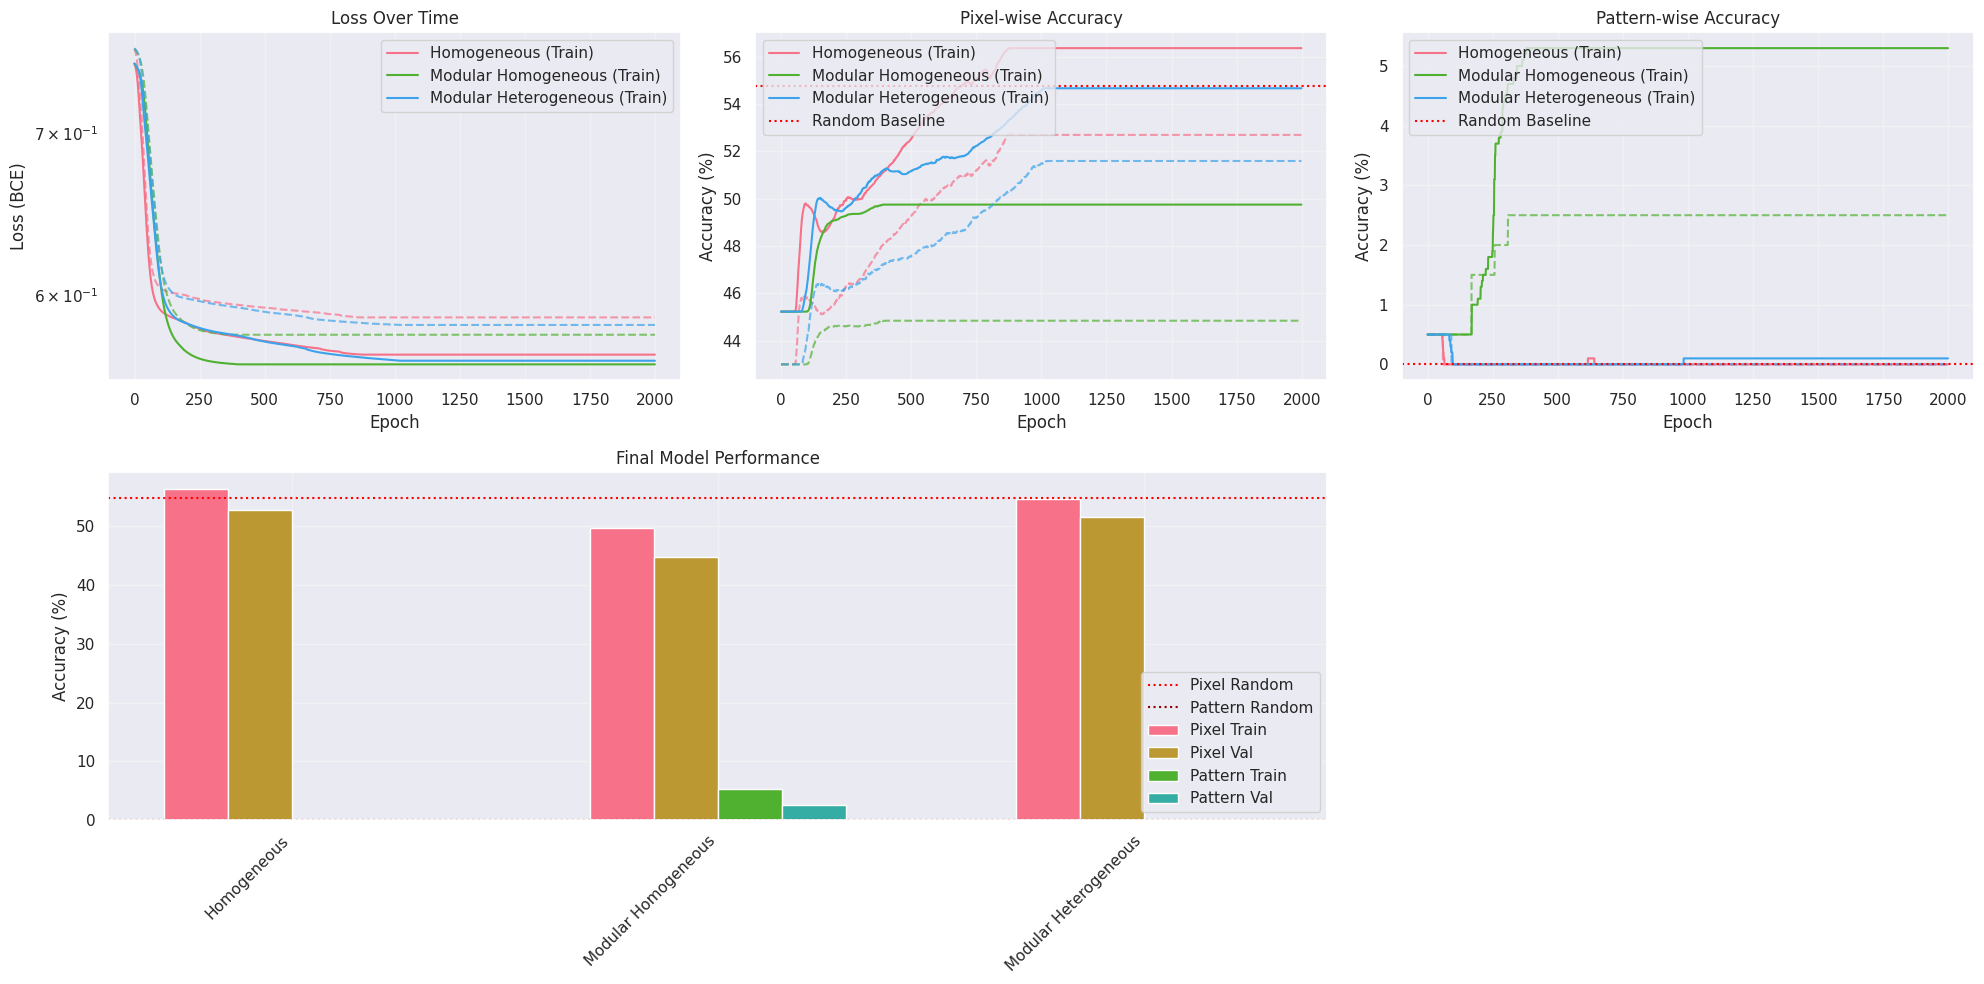


Visualizing pattern completion results...

Generating visualizations for Homogeneous...


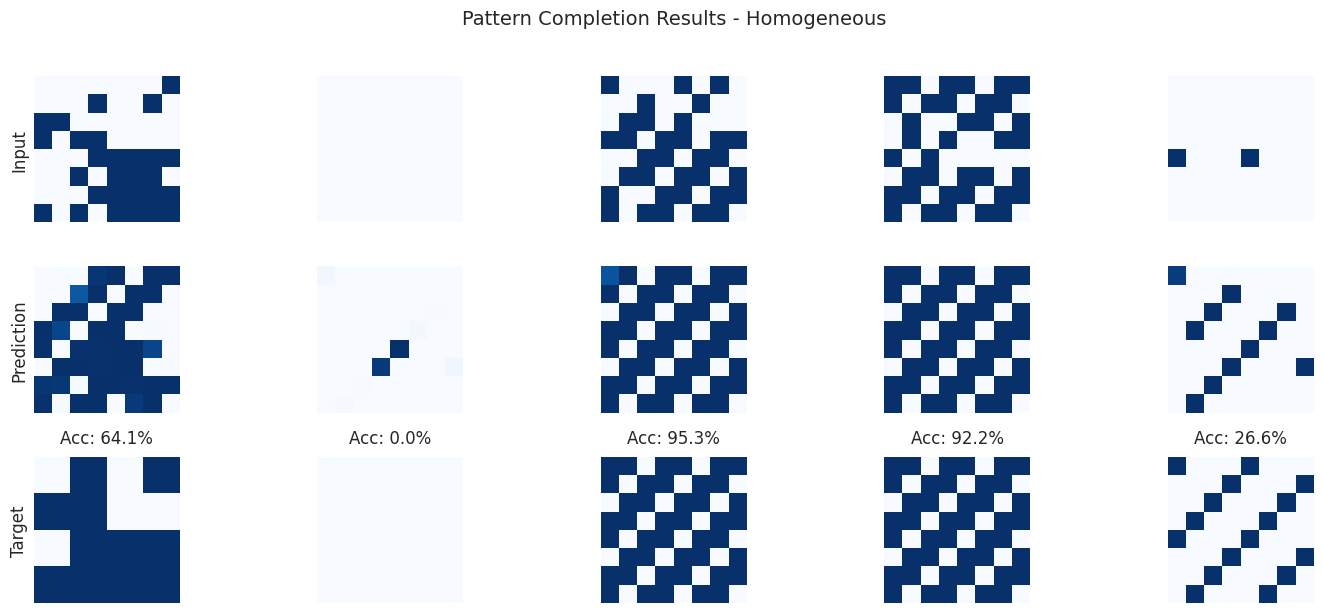


Generating visualizations for Modular Homogeneous...


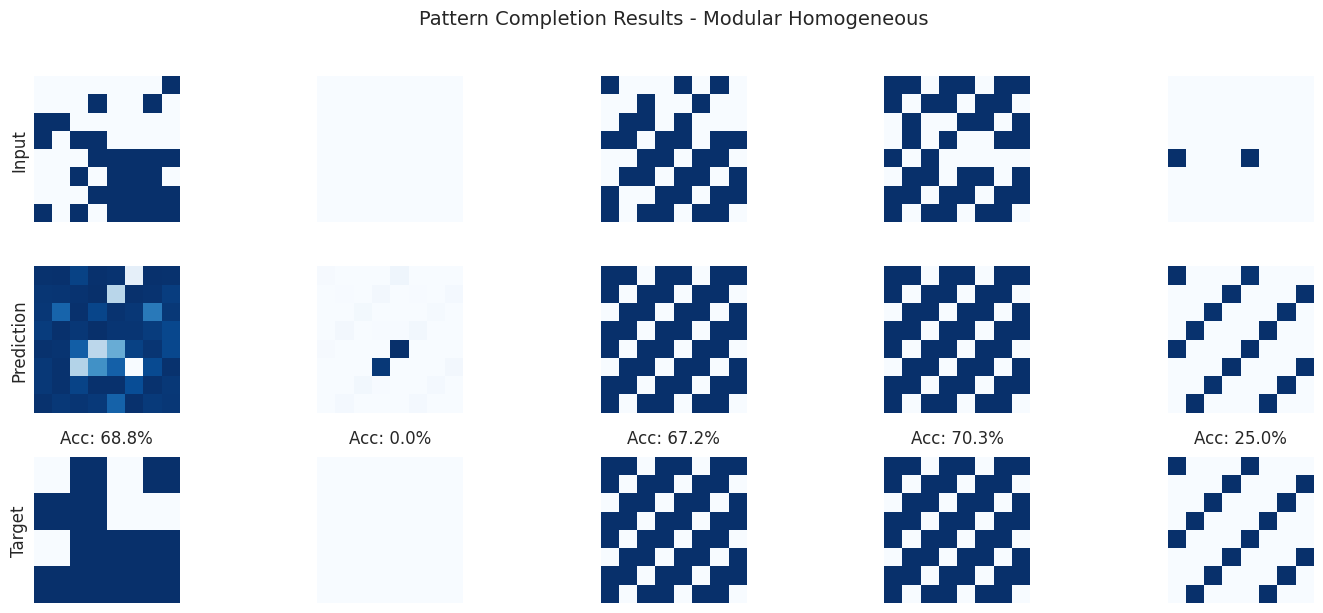

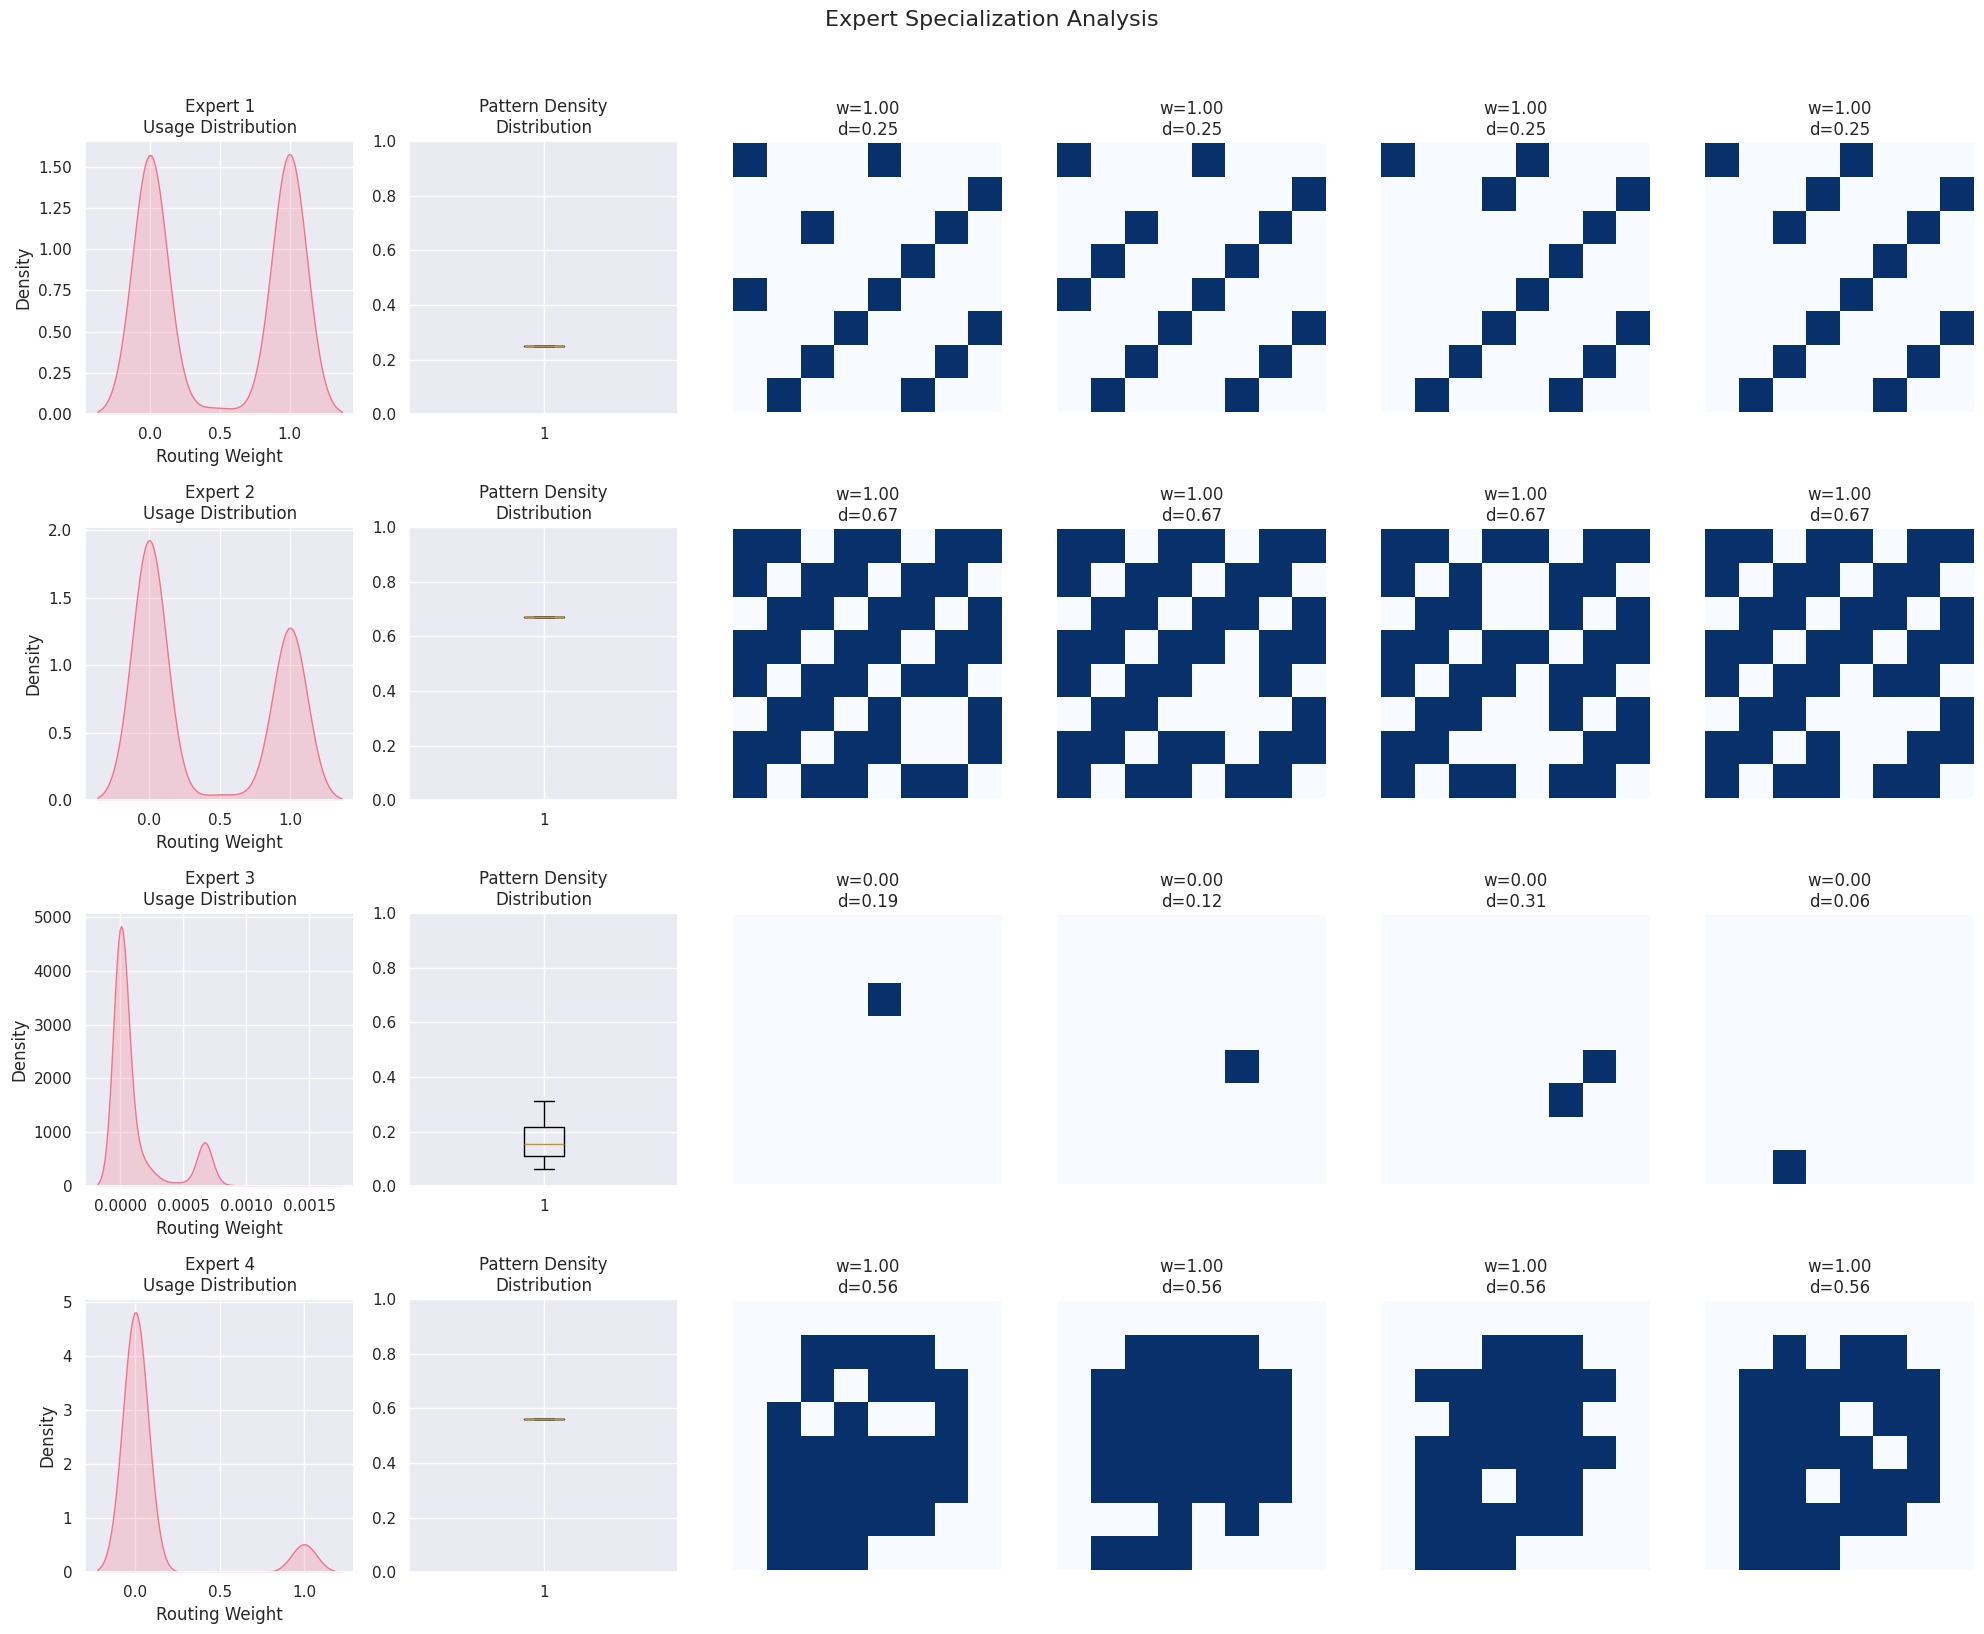


Generating visualizations for Modular Heterogeneous...


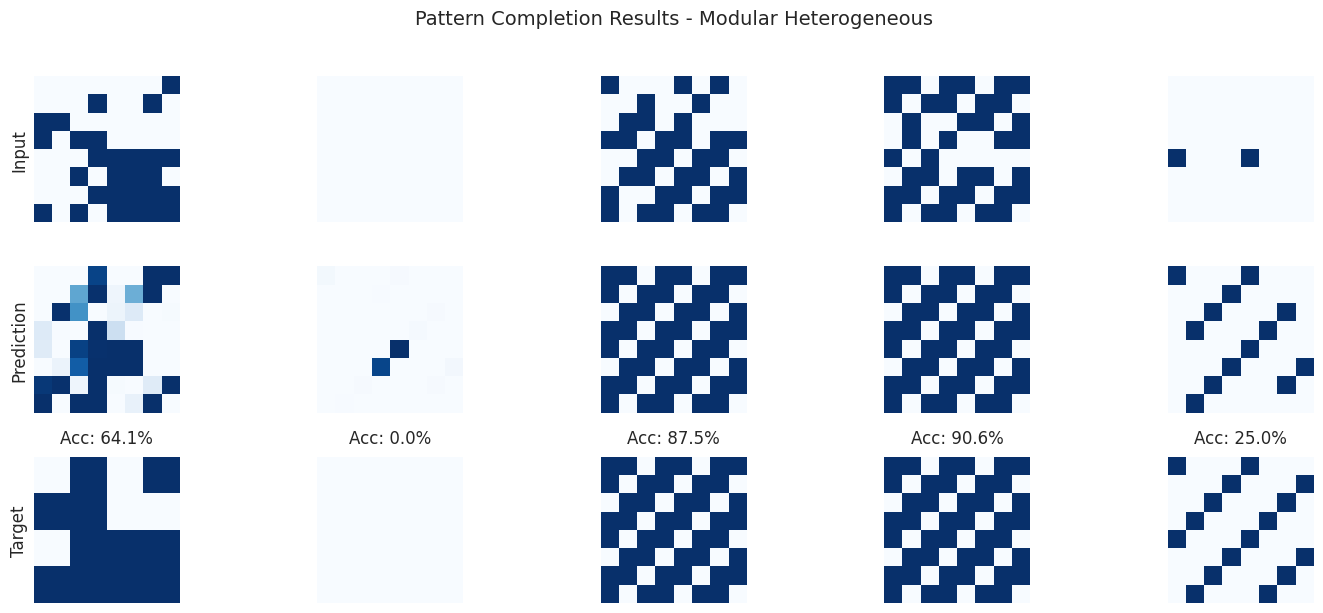

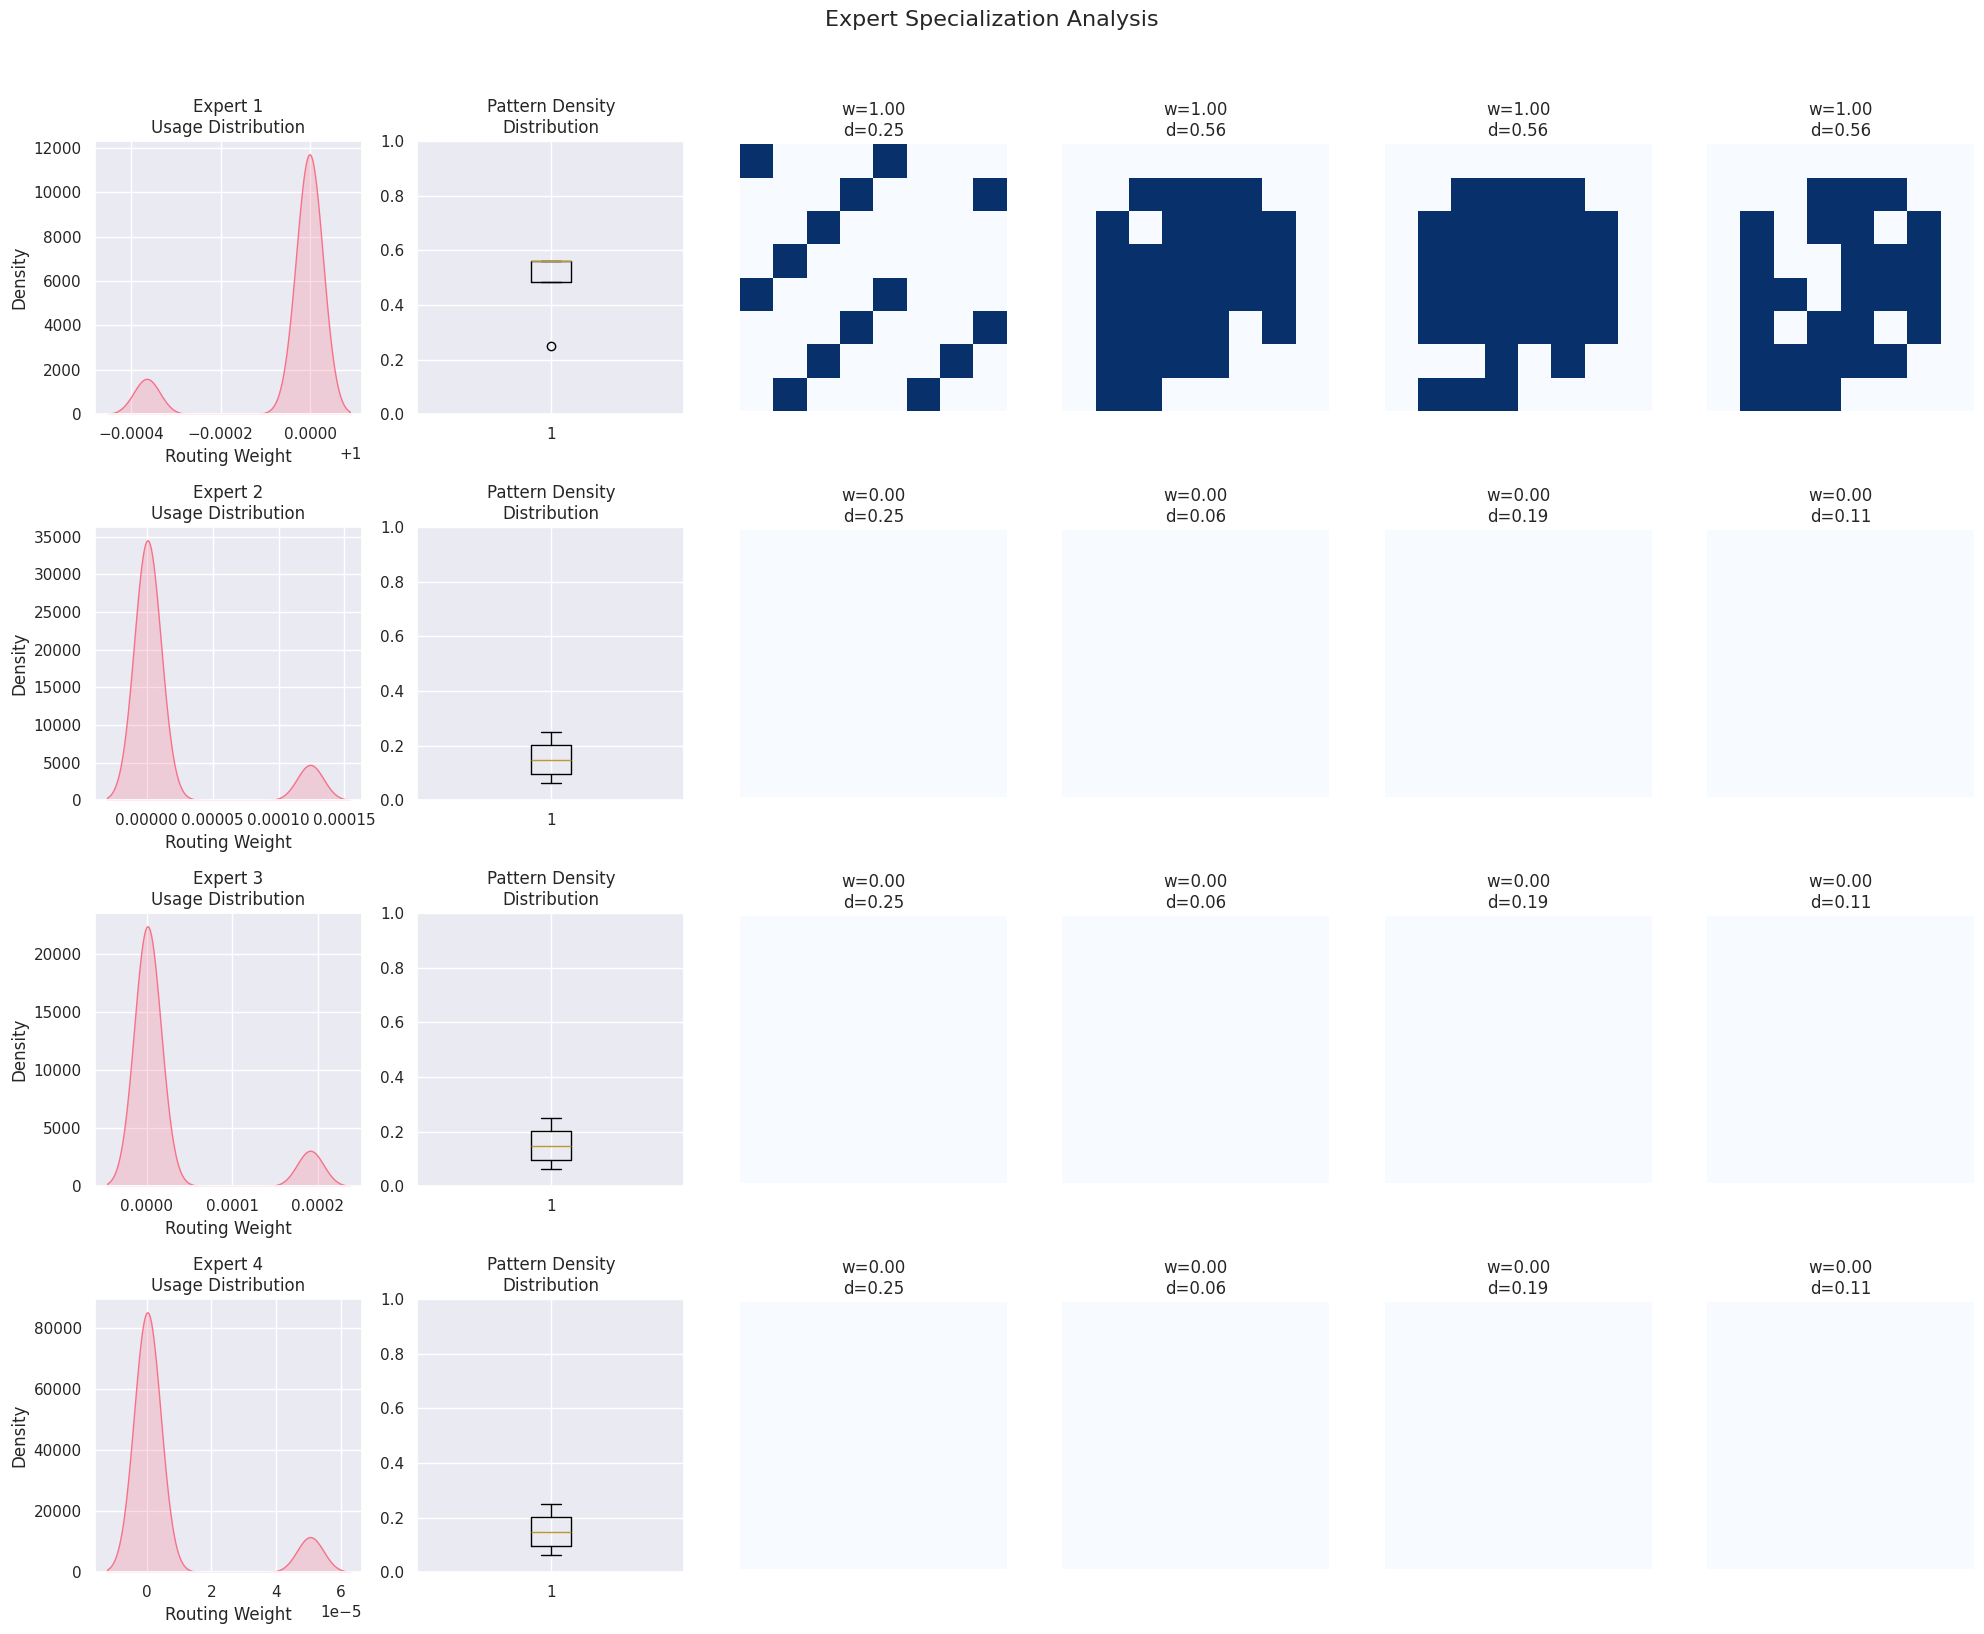


Final Performance Summary:
------------------------------------------------------------
Model                   Pixel Acc  Pattern Acc
------------------------------------------------------------
Homogeneous                52.70%        0.00%
Modular Homogeneous        44.84%        2.50%
Modular Heterogeneous       51.59%        0.00%
------------------------------------------------------------
Random Baseline            54.77%        0.00%

Experiment completed successfully!


In [32]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple, Dict
import seaborn as sns
from tqdm import tqdm
from torchvision.utils import make_grid  # Added for dataset visualization
import pandas as pd

# Enable better plots
# plt.style.use('seaborn')  # This line is causing the error
# Instead of using 'seaborn' as a style, which is not available in Matplotlib,
# we can directly use Seaborn to set the style
sns.set_theme(style="darkgrid")  # Use Seaborn to set the overall style
sns.set_palette("husl")  # Set the color palette using Seaborn
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 12

def run_pattern_completion_experiment():
    """Run the complete pattern completion experiment with enhanced visualization"""

    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)

    # Set parameters
    grid_size = 8
    input_size = grid_size * grid_size
    total_params = 20000
    num_experts = 4
    num_epochs = 2000

    # Generate data
    print("\nGenerating datasets...")
    train_size = 1000
    val_size = 200
    test_size = 50

    train_data, train_targets = generate_complex_patterns(train_size, grid_size)
    val_data, val_targets = generate_complex_patterns(val_size, grid_size)
    test_data, test_targets = generate_complex_patterns(test_size, grid_size)

    # Calculate baselines
    pixel_baseline, pattern_baseline = calculate_baselines(train_targets)
    print(f"\nBaseline Accuracies:")
    print(f"Pixel-wise: {pixel_baseline:.2f}%")
    print(f"Pattern-wise: {pattern_baseline:.4f}%")

    # First, analyze and visualize the dataset
    print("\nAnalyzing dataset characteristics...")
    fig_data = plt.figure(figsize=(15, 5))

    # Plot density distribution
    plt.subplot(131)
    densities = [train_targets[i].mean().item() for i in range(len(train_targets))]
    sns.histplot(densities, bins=30)
    plt.title('Pattern Density Distribution')
    plt.xlabel('Density')
    plt.ylabel('Count')

    # Plot example patterns
    plt.subplot(132)
    num_examples = 16
    sample_idx = np.random.choice(len(train_data), num_examples, replace=False)
    img_grid = make_grid(train_targets[sample_idx].reshape(-1, 1, grid_size, grid_size),
                        nrow=4, padding=1, normalize=True)
    plt.imshow(img_grid[0], cmap='Blues')
    plt.title('Sample Target Patterns')
    plt.axis('off')

    # Plot example masks
    plt.subplot(133)
    img_grid = make_grid(train_data[sample_idx].reshape(-1, 1, grid_size, grid_size),
                        nrow=4, padding=1, normalize=True)
    plt.imshow(img_grid[0], cmap='Blues')
    plt.title('Sample Input Patterns')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Initialize models
    print("\nInitializing models...")
    homogeneous = HomogeneousNetwork(input_size, total_params)
    mod_homogeneous = ModularHomogeneous(input_size, total_params, num_experts)
    expert_ratios = [0.5, 0.2, 0.2, 0.1]
    mod_heterogeneous = ModularHeterogeneous(input_size, total_params, expert_ratios)

    models = {
        'Homogeneous': homogeneous,
        'Modular Homogeneous': mod_homogeneous,
        'Modular Heterogeneous': mod_heterogeneous
    }

    # Train all models
    print("\nTraining models...")
    histories = {}

    for name, model in models.items():
        print(f"\nTraining {name} model...")
        history = train_and_evaluate(
            model=model,
            train_data=train_data,
            train_targets=train_targets,
            val_data=val_data,
            val_targets=val_targets,
            epochs=num_epochs
        )
        histories[name] = history

    # Plot training metrics
    print("\nGenerating training visualizations...")
    plot_training_metrics(histories, pixel_baseline, pattern_baseline)
    plt.show()

    # Visualize pattern completion results
    print("\nVisualizing pattern completion results...")
    for name, model in models.items():
        print(f"\nGenerating visualizations for {name}...")
        # Pattern completion visualization
        fig = visualize_pattern_completion(model, test_data, test_targets, name, grid_size)
        plt.show()

        # Expert specialization for modular models
        if 'Modular' in name:
            fig = visualize_expert_specialization(model, train_data, train_targets, grid_size)
            if fig is not None:
                plt.show()

    # Print final performance summary
    print("\nFinal Performance Summary:")
    print("-" * 60)
    print(f"{'Model':<20} {'Pixel Acc':>12} {'Pattern Acc':>12}")
    print("-" * 60)

    for name, history in histories.items():
        final_pixel_acc = history['val_pixel_acc'][-1]
        final_pattern_acc = history['val_pattern_acc'][-1]
        print(f"{name:<20} {final_pixel_acc:>11.2f}% {final_pattern_acc:>11.2f}%")

    print("-" * 60)
    print(f"{'Random Baseline':<20} {pixel_baseline:>11.2f}% {pattern_baseline:>11.2f}%")

    return models, histories

if __name__ == "__main__":
    print("Starting Pattern Completion Experiment...")
    print("=" * 60)

    # Check if CUDA is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    try:
        # Run the experiment
        models, histories = run_pattern_completion_experiment()
        print("\nExperiment completed successfully!")

    except Exception as e:
        print(f"\nAn error occurred during the experiment:")
        print(f"Error: {str(e)}")
        raise